# Evaluate MIGHT predictions on simulated datasets

First, we evaluate on variations of the Trunk dataset.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import os
from collections import defaultdict
from itertools import product
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from hyppo.conditional import ConditionalDcorr
from joblib import Parallel, delayed
from scipy.special import expit
from scipy.stats import entropy, ortho_group
from sklearn.datasets import (
    make_blobs,
    make_classification,
    make_sparse_spd_matrix,
    make_spd_matrix,
)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import (
    StratifiedKFold,
    StratifiedShuffleSplit,
    cross_val_score,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.utils import resample
from sktree import HonestForestClassifier, RandomForestClassifier, RandomForestRegressor
from sktree.datasets import make_trunk_classification
from sktree.datasets.multiview import make_gaussian_mixture, make_joint_factor_model
from sktree.stats import (
    FeatureImportanceForestClassifier,
    FeatureImportanceForestRegressor,
    PermutationForestRegressor,
    PermutationTest,
    build_hyppo_cv_forest,
    build_hyppo_oob_forest,
)
from sktree.stats.utils import (
    METRIC_FUNCTIONS,
    POSITIVE_METRICS,
    POSTERIOR_FUNCTIONS,
    REGRESSOR_METRICS,
    _compute_null_distribution_coleman,
    _non_nan_samples,
)
from sktree.tree import DecisionTreeClassifier, MultiViewDecisionTreeClassifier

seed = 12345
rng = np.random.default_rng(seed)

In [3]:
n_samples = 1000
n_dim = 10

In [4]:
def partial_roc_auc_score(y_true, y_score, max_fpr=0.1):
    n_trees, n_samples, n_classes = y_score.shape

    # Compute nan-averaged y_score along the trees axis
    y_score_avg = np.nanmean(y_score, axis=0)

    # Extract true labels and nan-averaged predicted scores for the positive class
    y_true = y_true.ravel()

    y_score_binary = y_score_avg[:, 1]

    # Identify rows with NaN values in y_score_binary
    nan_rows = np.isnan(y_score_binary)

    # Remove NaN rows from y_score_binary and y_true
    y_score_binary = y_score_binary[~nan_rows]
    y_true = y_true[~nan_rows]

    # Compute ROC AUC for binary classification
    pauc = roc_auc_score(y_true, y_score_binary, max_fpr=max_fpr)
    return pauc

In [5]:
def sensitivity_at_specificity(y_true, y_score, target_specificity=0.98, pos_label=1):
    n_trees, n_samples, n_classes = y_score.shape

    # Compute nan-averaged y_score along the trees axis
    y_score_avg = np.nanmean(y_score, axis=0)

    # Extract true labels and nan-averaged predicted scores for the positive class
    y_true = y_true.ravel()
    y_score_binary = y_score_avg[:, 1]

    # Identify rows with NaN values in y_score_binary
    nan_rows = np.isnan(y_score_binary)

    # Remove NaN rows from y_score_binary and y_true
    y_score_binary = y_score_binary[~nan_rows]
    y_true = y_true[~nan_rows]

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_score_binary, pos_label=pos_label)

    # Find the threshold corresponding to the target specificity
    index = np.argmax(fpr >= (1 - target_specificity))
    threshold_at_specificity = thresholds[index]

    # Compute sensitivity at the chosen specificity
    # sensitivity = tpr[index]
    # return sensitivity

    # Use the threshold to classify predictions
    y_pred_at_specificity = (y_score_binary >= threshold_at_specificity).astype(int)

    # Compute sensitivity at the chosen specificity
    sensitivity = np.sum((y_pred_at_specificity == 1) & (y_true == 1)) / np.sum(
        y_true == 1
    )

    return sensitivity

In [6]:
def mutual_information(y_true, y_score):
    n_trees, n_samples, n_classes = y_score.shape

    # Compute nan-averaged y_score along the trees axis
    y_score_avg = np.nanmean(y_score, axis=0)

    # Extract true labels and nan-averaged predicted scores for the positive class
    y_true = y_true.ravel()
    y_score_binary = y_score_avg[:, 1]

    # Identify rows with NaN values in y_score_binary
    nan_rows = np.isnan(y_score_binary)

    # Remove NaN rows from y_score_binary and y_true
    y_score_binary = y_score_binary[~nan_rows]
    y_true = y_true[~nan_rows]

    if y_true.squeeze().ndim != 1:
        raise ValueError(f"y_true must be 1d, not {y_true.shape}")

    # entropy averaged over n_samples
    H_YX = np.mean(entropy(y_score_avg[~nan_rows], base=np.exp(1), axis=1))
    # empirical count of each class (n_classes)
    _, counts = np.unique(y_true, return_counts=True)
    H_Y = entropy(counts, base=np.exp(1))
    return H_Y - H_YX

In [7]:
def _run_simulation(
    est,
    n_samples,
    n_dims,
    idx,
    root_dir,
    sim_name,
    model_name,
    overwrite=False,
    oob=True,
    cv=5,
):
    n_dims_ = 4096
    n_samples_ = 4096
    test_size = 0.2
    overwrite = True

    results = defaultdict(list)

    fname = (
        root_dir / "data" / sim_name / f"{sim_name}_{n_samples_}_{n_dims_}_{idx}.npz"
    )
    if not fname.exists():
        raise RuntimeError(f"{fname} does not exist")

    # print(f"Reading {fname}")
    data = np.load(fname, allow_pickle=True)
    X, y = data["X"], data["y"]

    if n_samples < X.shape[0]:
        _cv = StratifiedShuffleSplit(n_splits=1, train_size=n_samples)
        for train_idx, _ in _cv.split(X, y):
            continue
        X = X[train_idx, :]
        y = y[train_idx, ...].squeeze()
    if n_dims < X.shape[1]:
        X = X[:, :n_dims]

    output_fname = (
        root_dir
        / "output"
        / model_name
        / sim_name
        / f"{sim_name}_{n_samples}_{n_dims}_{idx}.npz"
    )
    output_fname.parent.mkdir(exist_ok=True, parents=True)
    if not output_fname.exists() or overwrite:
        if oob:
            est, posterior_arr = build_hyppo_oob_forest(
                est,
                X,
                y,
                verbose=False,
            )

            mi = mutual_information(y, posterior_arr)

            # generate S@S98 from posterior array
            sas98 = sensitivity_at_specificity(
                y, posterior_arr, target_specificity=0.98
            )

            # generate partial-AUC from posterior array
            pauc = partial_roc_auc_score(y, posterior_arr, max_fpr=0.1)
        else:
            est, posterior_arr = build_hyppo_cv_forest(
                est,
                X,
                y,
                cv=cv,
                test_size=test_size,
                seed=seed,
                verbose=False,
            )

            # Estimate CMI with
            mi = np.mean([mutual_information(y, arr) for arr in posterior_arr])
            sas98 = np.mean(
                [
                    sensitivity_at_specificity(y, arr, target_specificity=0.98)
                    for arr in posterior_arr
                ]
            )
            pauc = np.mean(
                [partial_roc_auc_score(y, arr, max_fpr=0.1) for arr in posterior_arr]
            )

        np.savez_compressed(
            output_fname,
            idx=idx,
            n_samples=n_samples,
            n_dims=n_dims,
            mi=mi,
            pauc=pauc,
            sas98=sas98,
            sim_type=sim_name,
        )
    else:
        # Load data from the compressed npz file
        loaded_data = np.load(output_fname)

        # Extract variables with the same names
        idx = loaded_data["idx"]
        n_samples = loaded_data["n_samples"]
        n_dims = loaded_data["n_dims"]
        mi = loaded_data["mi"]
        pauc = loaded_data["pauc"]
        sas98 = loaded_data["sas98"]
        sim_name = loaded_data["sim_type"]

    results["idx"].append(idx)
    results["n_samples"].append(n_samples)
    results["n_dims"].append(n_dims)
    results["mi"].append(mi)
    results["pauc"].append(pauc)
    results["sas98"].append(sas98)
    results["sim_type"].append(sim_name)
    return results

In [8]:
SIMULATIONS = {
    "1": {},
    "2": {"m_factor": 1},
    "3": {"band_type": "ar", "rho": 0.5},
    "4": {"band_type": "ar", "m_factor": 1, "rho": 0.5},
    # "5": {"mix": 0.5},
}
SIMULATIONS_NAMES = {
    "1": "trunk",
    "2": "trunk-overlap",
    "3": "trunk-banded",
    "4": "trunk-banded-overlap",
    # "5": "trunk-mix",
}
n_dims_list = [2**i for i in range(12)]
n_dims_list[0] = 1
n_dims = 2048
n_samples = 524

n_repeats = 5
n_samples_list = [2**x for x in range(8, 13)]
n_samples_ = 4096
n_dims_ = 4096

print(n_samples_list)
print(n_dims_list)
print(n_samples_)

[256, 512, 1024, 2048, 4096]
[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]
4096


In [9]:
root_dir = Path("/Volumes/Extreme Pro/cancer")

In [10]:
### hard-coded parameters
n_estimators = 500
max_features = 0.3
test_size = 0.2
n_jobs = -1

## Visualize Sample Datasets

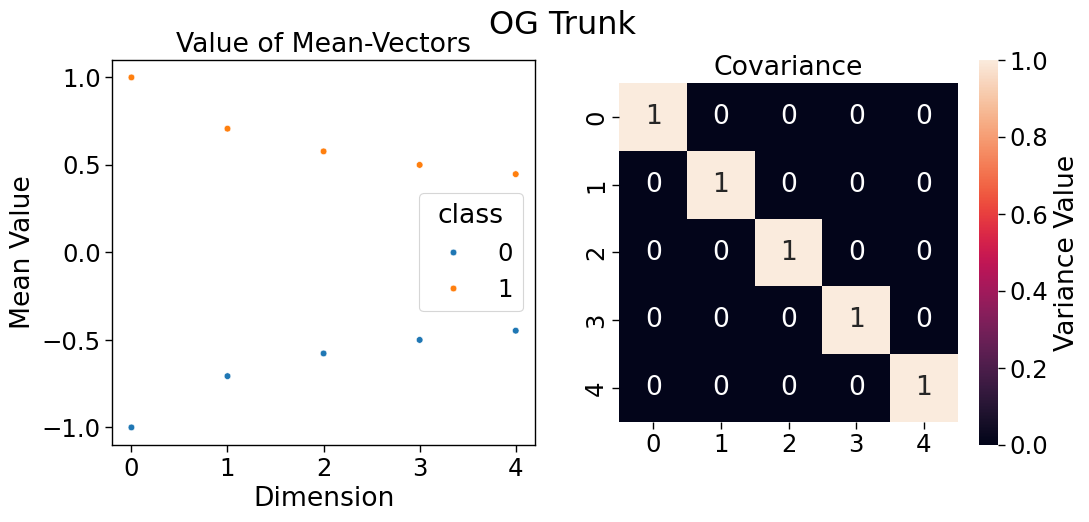

In [4]:
X, y, means, covs = make_trunk_classification(
    n_samples=n_samples,
    n_dim=n_dim,
    n_informative=5,
    mix=0.5,
    m_factor=-1.0,
    return_params=True,
)

df = pd.DataFrame(means).T
df.reset_index(inplace=True)
df.columns = ["dimension", "0", "1"]
df = pd.melt(df, id_vars=("dimension",), value_name="mean", var_name="class")

sns.set_context("paper", font_scale=2.0)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ax = sns.scatterplot(x="dimension", y="mean", hue="class", data=df, ax=axs[0])
ax.set(xlabel="Dimension", ylabel="Mean Value", title="Value of Mean-Vectors")

ax = sns.heatmap(
    covs[0], annot=True, square=True, ax=axs[1], cbar_kws={"label": "Variance Value"}
)
ax.set_title("Covariance")
fig.suptitle("OG Trunk")
plt.show()

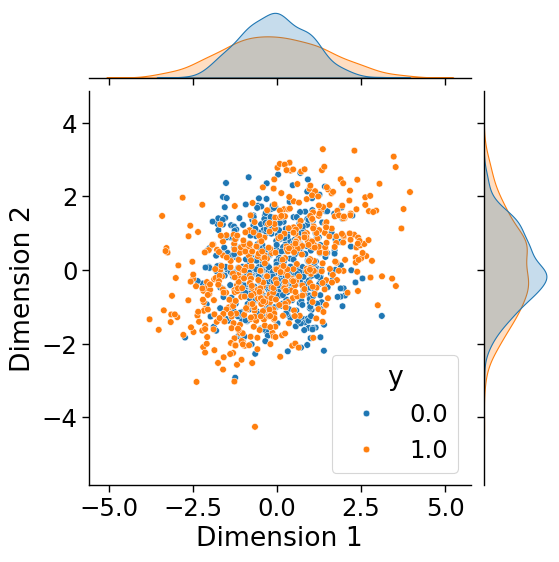

In [169]:
# Combine X and y into a DataFrame
data = pd.DataFrame({"Dimension 1": X[:, 0], "Dimension 2": X[:, 1], "y": y})

# Create a joint plot with different colors for y == 0 and y == 1
sns.jointplot(data=data, x="Dimension 1", y="Dimension 2", hue="y", kind="scatter")
plt.show()
# # Create a joint plot
# sns.jointplot(x=X[np.argwhere(y == 1).squeeze(), 0], y=X[np.argwhere(y == 1).squeeze(), 1], kind="scatter")
# sns.jointplot(x=X[np.argwhere(y == 0).squeeze(), 0], y=X[np.argwhere(y == 0).squeeze(), 1], kind="scatter")
# # sns.jointplot(x=X[:, 0], y=X[:, 1], kind="scatter")

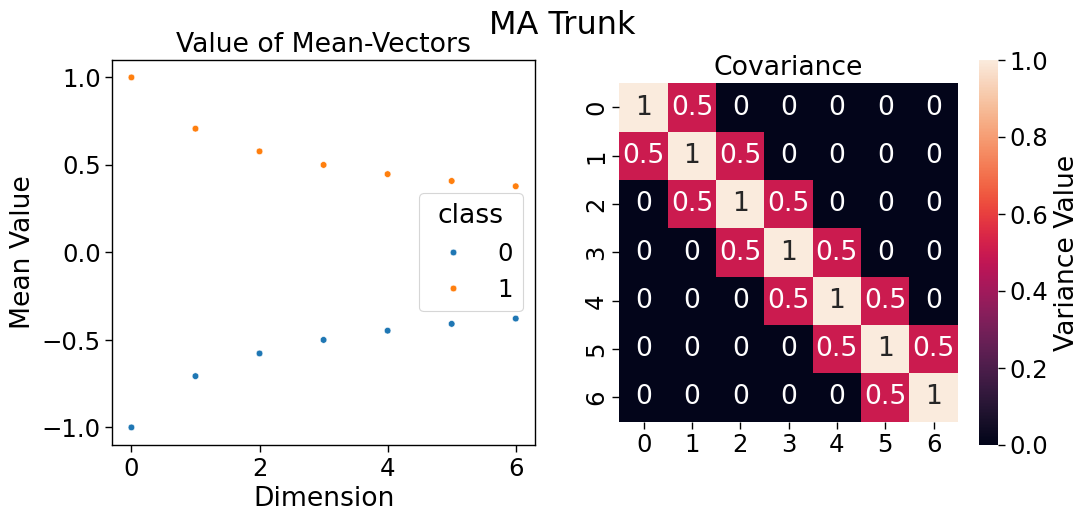

In [5]:
X, y, means, covs = make_trunk_classification(
    n_samples=n_samples, n_dim=n_dim, rho=0.5, return_params=True
)

df = pd.DataFrame(means).T
df.reset_index(inplace=True)
df.columns = ["dimension", "0", "1"]
df = pd.melt(df, id_vars=("dimension",), value_name="mean", var_name="class")

sns.set_context("paper", font_scale=2.0)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ax = sns.scatterplot(x="dimension", y="mean", hue="class", data=df, ax=axs[0])
ax.set(xlabel="Dimension", ylabel="Mean Value", title="Value of Mean-Vectors")

ax = sns.heatmap(
    covs[0], annot=True, square=True, ax=axs[1], cbar_kws={"label": "Variance Value"}
)
ax.set_title("Covariance")
fig.suptitle("MA Trunk")
plt.show()

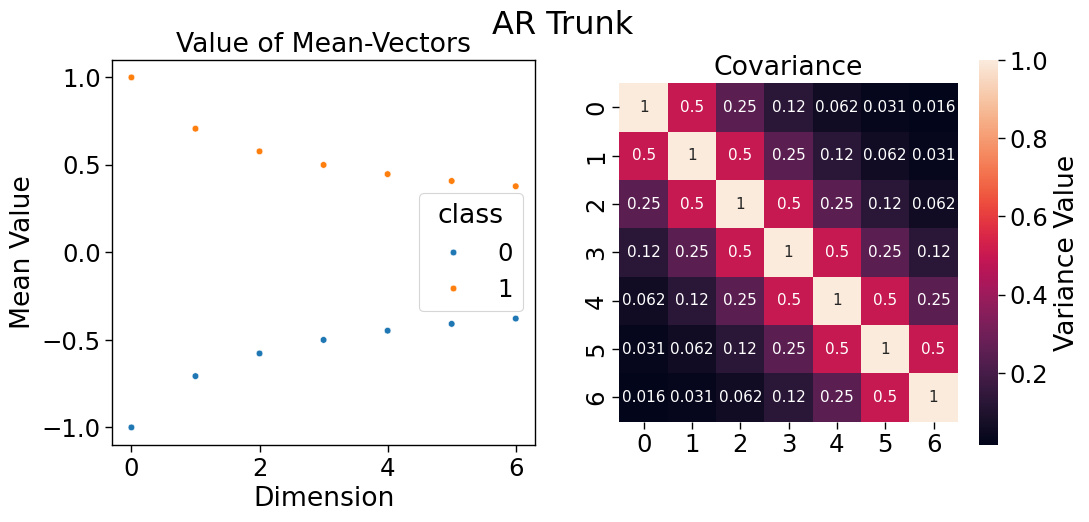

In [6]:
X, y, means, covs = make_trunk_classification(
    n_samples=n_samples, n_dim=n_dim, rho=0.5, band_type="ar", return_params=True
)

df = pd.DataFrame(means).T
df.reset_index(inplace=True)
df.columns = ["dimension", "0", "1"]
df = pd.melt(df, id_vars=("dimension",), value_name="mean", var_name="class")

sns.set_context("paper", font_scale=2.0)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ax = sns.scatterplot(x="dimension", y="mean", hue="class", data=df, ax=axs[0])
ax.set(xlabel="Dimension", ylabel="Mean Value", title="Value of Mean-Vectors")

ax = sns.heatmap(
    np.round(covs[0], 3),
    annot=True,
    square=True,
    ax=axs[1],
    annot_kws={"size": 11},
    cbar_kws={"label": "Variance Value"},
)
ax.set_title("Covariance")

fig.suptitle("AR Trunk")
plt.show()

# Generate Datasets to Run MIGHT

Now, for each simulation setting, we will generate 100 random instances and then run MIGHT on all.

F = N(mu, I), G = N(-mu, I) = trunk
F = N(mu, I), G = N(mu, I) = trunk-overlap
F = N(mu, epsilon), G = N(-mu, epsilon), epsilon has 1 on the diagonal, sigma_ij = rho^|i-j|  = trunk-banded
F = N(mu, epsilon), G = N(mu, epsilon) = trunk-banded-overlap
F = N(0, I), G = pi N(mu, I) + (1-pi) N(-mu, I) = trunk-mixture

In [12]:
root_dir = Path("/Volumes/Extreme Pro/cancer")

In [44]:
for sim_number in range(1, 5):
    for idx in range(n_repeats):
        sim_name = SIMULATIONS_NAMES[str(sim_number)]
        fname = (
            root_dir
            / "data"
            / sim_name
            / f"{sim_name}_{n_samples_}_{n_dims_}_{idx}.npz"
        )

        fname.parent.mkdir(exist_ok=True, parents=True)
        X, y = make_trunk_classification(
            n_samples=n_samples_, n_dim=n_dims_, **SIMULATIONS[str(sim_number)]
        )
        # save the dataset somewhere
        np.savez_compressed(fname, X=X, y=y)

## Parallelized Data Generation

In [68]:
# Parallelize the loop
num_simulations = 5  # Set to the number of simulations you have
num_jobs = -1  # Use all available CPU cores
n_dims_ = 4096
n_samples_ = 2048


def generate_data(sim_number, n_samples, idx, overwrite=False):
    sim_name = SIMULATIONS_NAMES[str(sim_number)]
    fname = (
        root_dir / "data" / sim_name / f"{sim_name}_{n_samples_}_{n_dims_}_{idx}.npz"
    )

    if not fname.exists() or overwrite:
        fname.parent.mkdir(exist_ok=True, parents=True)
        X, y = make_trunk_classification(
            n_samples=n_samples_, n_dim=n_dims_, **SIMULATIONS[str(sim_number)]
        )
        np.savez(fname, X=X, y=y)
        return (sim_number, n_samples, idx)


results = Parallel(n_jobs=num_jobs)(
    delayed(generate_data)(sim_number, n_samples, idx, False)
    for sim_number in range(1, num_simulations + 1)
    for idx in range(n_repeats)
    for n_samples in n_samples_list
)

print("done")

done


# Run MIGHT with bootstrapping in layers

bootstrapv4

In [23]:
model_name = "bootstrapv4"
print(n_samples_list, n_repeats, n_dims, n_repeats, root_dir, model_name)

# _run_simulation(n_samples, n_dims, idx, root_dir, sim_name, model_name)

[256, 512, 1024, 2048, 4096] 5 2048 5 /Volumes/Extreme Pro/cancer bootstrapv4


In [192]:
MODEL_NAMES = {
    # "might-honestfraction05-bootstrap-x5": {
    #     "n_estimators": n_estimators * 5,
    #     "random_state": seed,
    #     "honest_fraction": 0.5,
    #     "n_jobs": n_jobs,
    #     "bootstrap": True,
    #     "stratify": True,
    # },
    # "might-honestfraction05-bootstrap-maxsamples127": {
    #     "n_estimators": n_estimators,
    #     "random_state": seed,
    #     "honest_fraction": 0.5,
    #     "n_jobs": n_jobs,
    #     "bootstrap": True,
    #     "stratify": True,
    #     "max_samples": 1.27,
    # },
    "might-honestfraction05-bootstrap-maxsamples16x5": {
        "n_estimators": n_estimators * 5,
        "random_state": seed,
        "honest_fraction": 0.5,
        "n_jobs": n_jobs,
        "bootstrap": True,
        "stratify": True,
        "max_samples": 1.6,
    },
    # "might-honestfraction025-bootstrap": {
    #     "n_estimators": n_estimators,
    #     "random_state": seed,
    #     "honest_fraction": 0.25,
    #     "n_jobs": n_jobs,
    #     "bootstrap": True,
    #     "stratify": True,
    # },
    # "might-honestfraction075-bootstrap": {
    #     "n_estimators": n_estimators,
    #     "random_state": seed,
    #     "honest_fraction": 0.75,
    #     "n_jobs": n_jobs,
    #     "bootstrap": True,
    #     "stratify": True,
    # },
    # "might-honestfraction05-honestbootstrap": {
    #     "n_estimators": n_estimators,
    #     "random_state": seed,
    #     "honest_fraction": 0.5,
    #     "n_jobs": n_jobs,
    #     "bootstrap": True,
    #     "stratify": True,
    #     "honest_bootstrap": True,
    # },
}

In [185]:
NORMAL_MODEL_NAMES = {
    "might-honestfraction05": {
        "n_estimators": n_estimators,
        "random_state": seed,
        "honest_fraction": 0.5,
        "n_jobs": n_jobs,
        "bootstrap": False,
        "stratify": True,
    },
    # "might-honestfraction05-5x": {
    #     "n_estimators": n_estimators * 5,
    #     "random_state": seed,
    #     "honest_fraction": 0.5,
    #     "n_jobs": n_jobs,
    #     "bootstrap": False,
    #     "stratify": True,
    # },
}


CV_MODEL_NAMES = {
    "might-honestfraction05-5fold": {
        "n_estimators": n_estimators,
        "random_state": seed,
        "honest_fraction": 0.5,
        "n_jobs": n_jobs,
        "bootstrap": False,
        "stratify": True,
    },
}

In [ ]:
oob = True
overwrite = False
for model_name, kwargs in MODEL_NAMES.items():
    # Parallelize the simulations using joblib
    # train MIGHT
    est = HonestForestClassifier(**kwargs)

    results = Parallel(n_jobs=-1)(
        delayed(_run_simulation)(
            est, n_samples, n_dims, idx, root_dir, sim_name, model_name, overwrite, oob
        )
        for sim_name in SIMULATIONS_NAMES.values()
        for n_samples in n_samples_list
        for idx in range(n_repeats)
    )

In [ ]:
oob = True
overwrite = False
n_samples = 512

for model_name, kwargs in MODEL_NAMES.items():
    # Parallelize the simulations using joblib
    # train MIGHT
    est = HonestForestClassifier(**kwargs)

    results = Parallel(n_jobs=-1)(
        delayed(_run_simulation)(
            est, n_samples, n_dims, idx, root_dir, sim_name, model_name, overwrite, oob
        )
        for sim_name in SIMULATIONS_NAMES.values()
        for n_dims in n_dims_list
        for idx in range(n_repeats)
    )

In [91]:
NORMAL_MODEL_NAMES = {
    "might-honestfraction05": {
        "n_estimators": n_estimators,
        "random_state": seed,
        "honest_fraction": 0.5,
        "n_jobs": n_jobs,
        "bootstrap": False,
        "stratify": True,
    },
    "might-honestfraction05-5x": {
        "n_estimators": n_estimators * 5,
        "random_state": seed,
        "honest_fraction": 0.5,
        "n_jobs": n_jobs,
        "bootstrap": False,
        "stratify": True,
    },
}


CV_MODEL_NAMES = {
    "might-honestfraction05-5fold": {
        "n_estimators": n_estimators,
        "random_state": seed,
        "honest_fraction": 0.5,
        "n_jobs": n_jobs,
        "bootstrap": False,
        "stratify": True,
    },
}

In [ ]:
oob = False
overwrite = False
for model_name, kwargs in NORMAL_MODEL_NAMES.items():
    # Parallelize the simulations using joblib
    # train MIGHT
    est = HonestForestClassifier(**kwargs)

    results = Parallel(n_jobs=-1)(
        delayed(_run_simulation)(
            est,
            n_samples,
            n_dims,
            idx,
            root_dir,
            sim_name,
            model_name,
            overwrite,
            oob,
            None,
        )
        for sim_name in SIMULATIONS_NAMES.values()
        for n_samples in n_samples_list
        for idx in range(n_repeats)
    )

/var/folders/6_/sl83qtkd68x3_mvfys07_6qm0000gn/T/ipykernel_6525/1133474242.py:5: RuntimeWarning: Mean of empty slice
/var/folders/6_/sl83qtkd68x3_mvfys07_6qm0000gn/T/ipykernel_6525/2116572530.py:5: RuntimeWarning: Mean of empty slice
/var/folders/6_/sl83qtkd68x3_mvfys07_6qm0000gn/T/ipykernel_6525/1133474242.py:5: RuntimeWarning: Mean of empty slice
/var/folders/6_/sl83qtkd68x3_mvfys07_6qm0000gn/T/ipykernel_6525/2116572530.py:5: RuntimeWarning: Mean of empty slice
/var/folders/6_/sl83qtkd68x3_mvfys07_6qm0000gn/T/ipykernel_6525/1133474242.py:5: RuntimeWarning: Mean of empty slice
/var/folders/6_/sl83qtkd68x3_mvfys07_6qm0000gn/T/ipykernel_6525/2116572530.py:5: RuntimeWarning: Mean of empty slice
/var/folders/6_/sl83qtkd68x3_mvfys07_6qm0000gn/T/ipykernel_6525/1133474242.py:5: RuntimeWarning: Mean of empty slice
/var/folders/6_/sl83qtkd68x3_mvfys07_6qm0000gn/T/ipykernel_6525/2116572530.py:5: RuntimeWarning: Mean of empty slice
/var/folders/6_/sl83qtkd68x3_mvfys07_6qm0000gn/T/ipykernel_6525/

In [64]:
oob = False
overwrite = False
n_samples = 512

for model_name, kwargs in NORMAL_MODEL_NAMES.items():
    # Parallelize the simulations using joblib
    # train MIGHT
    est = HonestForestClassifier(**kwargs)

    results = Parallel(n_jobs=-1)(
        delayed(_run_simulation)(
            est,
            n_samples,
            n_dims,
            idx,
            root_dir,
            sim_name,
            model_name,
            overwrite,
            oob,
            None,
        )
        for sim_name in SIMULATIONS_NAMES.values()
        for n_dims in n_dims_list
        for idx in range(n_repeats)
    )

/var/folders/6_/sl83qtkd68x3_mvfys07_6qm0000gn/T/ipykernel_11350/1133474242.py:5: RuntimeWarning: Mean of empty slice
/var/folders/6_/sl83qtkd68x3_mvfys07_6qm0000gn/T/ipykernel_11350/2116572530.py:5: RuntimeWarning: Mean of empty slice
/var/folders/6_/sl83qtkd68x3_mvfys07_6qm0000gn/T/ipykernel_11350/1133474242.py:5: RuntimeWarning: Mean of empty slice
/var/folders/6_/sl83qtkd68x3_mvfys07_6qm0000gn/T/ipykernel_11350/2116572530.py:5: RuntimeWarning: Mean of empty slice
/var/folders/6_/sl83qtkd68x3_mvfys07_6qm0000gn/T/ipykernel_11350/1133474242.py:5: RuntimeWarning: Mean of empty slice
/var/folders/6_/sl83qtkd68x3_mvfys07_6qm0000gn/T/ipykernel_11350/2116572530.py:5: RuntimeWarning: Mean of empty slice
/var/folders/6_/sl83qtkd68x3_mvfys07_6qm0000gn/T/ipykernel_11350/1133474242.py:5: RuntimeWarning: Mean of empty slice
/var/folders/6_/sl83qtkd68x3_mvfys07_6qm0000gn/T/ipykernel_11350/2116572530.py:5: RuntimeWarning: Mean of empty slice
/var/folders/6_/sl83qtkd68x3_mvfys07_6qm0000gn/T/ipykern

In [ ]:
oob = False
for model_name, kwargs in CV_MODEL_NAMES.items():
    # Parallelize the simulations using joblib
    # train MIGHT
    est = HonestForestClassifier(**kwargs)

    results = Parallel(n_jobs=-1)(
        delayed(_run_simulation)(
            est,
            n_samples,
            n_dims,
            idx,
            root_dir,
            sim_name,
            model_name,
            overwrite,
            oob,
            5,
        )
        for sim_name in SIMULATIONS_NAMES.values()
        for n_samples in n_samples_list
        for idx in range(n_repeats)
    )

In [65]:
n_samples = 512
oob = False
for model_name, kwargs in CV_MODEL_NAMES.items():
    # Parallelize the simulations using joblib
    # train MIGHT
    est = HonestForestClassifier(**kwargs)

    results = Parallel(n_jobs=-1)(
        delayed(_run_simulation)(
            est,
            n_samples,
            n_dims,
            idx,
            root_dir,
            sim_name,
            model_name,
            overwrite,
            oob,
            5,
        )
        for sim_name in SIMULATIONS_NAMES.values()
        for n_dims in n_dims_list
        for idx in range(n_repeats)
    )

/var/folders/6_/sl83qtkd68x3_mvfys07_6qm0000gn/T/ipykernel_11350/1133474242.py:5: RuntimeWarning: Mean of empty slice
/var/folders/6_/sl83qtkd68x3_mvfys07_6qm0000gn/T/ipykernel_11350/2225140639.py:5: RuntimeWarning: Mean of empty slice
/var/folders/6_/sl83qtkd68x3_mvfys07_6qm0000gn/T/ipykernel_11350/2225140639.py:5: RuntimeWarning: Mean of empty slice
/var/folders/6_/sl83qtkd68x3_mvfys07_6qm0000gn/T/ipykernel_11350/2225140639.py:5: RuntimeWarning: Mean of empty slice
/var/folders/6_/sl83qtkd68x3_mvfys07_6qm0000gn/T/ipykernel_11350/2225140639.py:5: RuntimeWarning: Mean of empty slice
/var/folders/6_/sl83qtkd68x3_mvfys07_6qm0000gn/T/ipykernel_11350/2116572530.py:5: RuntimeWarning: Mean of empty slice
/var/folders/6_/sl83qtkd68x3_mvfys07_6qm0000gn/T/ipykernel_11350/2116572530.py:5: RuntimeWarning: Mean of empty slice
/var/folders/6_/sl83qtkd68x3_mvfys07_6qm0000gn/T/ipykernel_11350/2116572530.py:5: RuntimeWarning: Mean of empty slice
/var/folders/6_/sl83qtkd68x3_mvfys07_6qm0000gn/T/ipykern

In [66]:
print("done")

done


# Make Plots

## Varying samples

In [195]:
# first consolidate
n_samples = 524
n_dims = 2048

results = defaultdict(list)

for model_name in [
    # "might-honestfraction05-bootstrap-x5",
    "might-honestfraction05-bootstrap",
    "might-honestfraction05-honestbootstrap",
    "might-honestfraction05-bootstrap-maxsamples127",
    "might-honestfraction05-bootstrap-maxsamples16",
    "might-honestfraction05-bootstrap-maxsamples16x5",
]:  # MODEL_NAMES.keys():
    print(model_name)
    for sim_number in range(1, 6):
        for idx in range(n_repeats):
            for n_samples in n_samples_list:
                sim_name = SIMULATIONS_NAMES[str(sim_number)]

                output_fname = (
                    root_dir
                    / "output"
                    / model_name
                    / sim_name
                    / f"{sim_name}_{n_samples}_{n_dims}_{idx}.npz"
                )
                # print(output_fname.exists())
                # Load data from the compressed npz file
                loaded_data = np.load(output_fname)

                # Extract variables with the same names
                idx = loaded_data["idx"]
                n_samples = loaded_data["n_samples"]
                n_dims = loaded_data["n_dims"]
                mi = loaded_data["mi"]
                pauc = loaded_data["pauc"]
                sas98 = loaded_data["sas98"]
                sim_name = loaded_data["sim_type"]

                results["idx"].append(idx)
                results["n_samples"].append(n_samples)
                results["n_dims"].append(n_dims)
                results["mi"].append(mi)
                results["pauc"].append(pauc)
                results["sas98"].append(sas98)
                results["sim_type"].append(sim_name)
                results["model"].append(model_name)

might-honestfraction05-bootstrap
might-honestfraction05-honestbootstrap
might-honestfraction05-bootstrap-maxsamples127
might-honestfraction05-bootstrap-maxsamples16
might-honestfraction05-bootstrap-maxsamples16x5


In [196]:
for model_name in CV_MODEL_NAMES.keys():
    print(model_name)
    for sim_number in range(1, 6):
        for idx in range(n_repeats):
            for n_samples in n_samples_list:
                sim_name = SIMULATIONS_NAMES[str(sim_number)]

                output_fname = (
                    root_dir
                    / "output"
                    / model_name
                    / sim_name
                    / f"{sim_name}_{n_samples}_{n_dims}_{idx}.npz"
                )
                # print(output_fname.exists())
                # Load data from the compressed npz file
                loaded_data = np.load(output_fname)

                # Extract variables with the same names
                idx = loaded_data["idx"]
                n_samples = loaded_data["n_samples"]
                n_dims = loaded_data["n_dims"]
                mi = loaded_data["mi"]
                pauc = loaded_data["pauc"]
                sas98 = loaded_data["sas98"]
                sim_name = loaded_data["sim_type"]

                results["idx"].append(idx)
                results["n_samples"].append(n_samples)
                results["n_dims"].append(n_dims)
                results["mi"].append(mi)
                results["pauc"].append(pauc)
                results["sas98"].append(sas98)
                results["sim_type"].append(sim_name)
                results["model"].append(model_name)

might-honestfraction05-5fold


In [197]:
for model_name in NORMAL_MODEL_NAMES.keys():
    print(model_name)
    for sim_number in range(1, 6):
        for idx in range(n_repeats):
            for n_samples in n_samples_list:
                sim_name = SIMULATIONS_NAMES[str(sim_number)]

                output_fname = (
                    root_dir
                    / "output"
                    / model_name
                    / sim_name
                    / f"{sim_name}_{n_samples}_{n_dims}_{idx}.npz"
                )
                # print(output_fname.exists())
                # Load data from the compressed npz file
                loaded_data = np.load(output_fname)

                # Extract variables with the same names
                idx = loaded_data["idx"]
                n_samples = loaded_data["n_samples"]
                n_dims = loaded_data["n_dims"]
                mi = loaded_data["mi"]
                pauc = loaded_data["pauc"]
                sas98 = loaded_data["sas98"]
                sim_name = loaded_data["sim_type"]

                results["idx"].append(idx)
                results["n_samples"].append(n_samples)
                results["n_dims"].append(n_dims)
                results["mi"].append(mi)
                results["pauc"].append(pauc)
                results["sas98"].append(sas98)
                results["sim_type"].append(sim_name)
                results["model"].append(model_name)

might-honestfraction05


In [198]:
truth_df = pd.DataFrame()

# load the truth values
for sim_name in np.unique(results["sim_type"]):
    if sim_name == "trunk-mix":
        continue
    truth_fname = root_dir / "data" / "truth" / f"{sim_name}.csv"

    truth_df_ = pd.read_csv(truth_fname, header=None)
    truth_df_.columns = ["true_sas98"]
    truth_df_["n_dims"] = [4, 8, 16, 32, 64, 128, 256]
    truth_df_["sim_type"] = sim_name

    truth_df = pd.concat((truth_df, truth_df_), axis=0)

In [199]:
print(n_dims)

n_dims_truth = 256

print(n_dims_truth)

2048
256


6    0.99814
Name: true_sas98, dtype: float64
6    0.86024
Name: true_sas98, dtype: float64


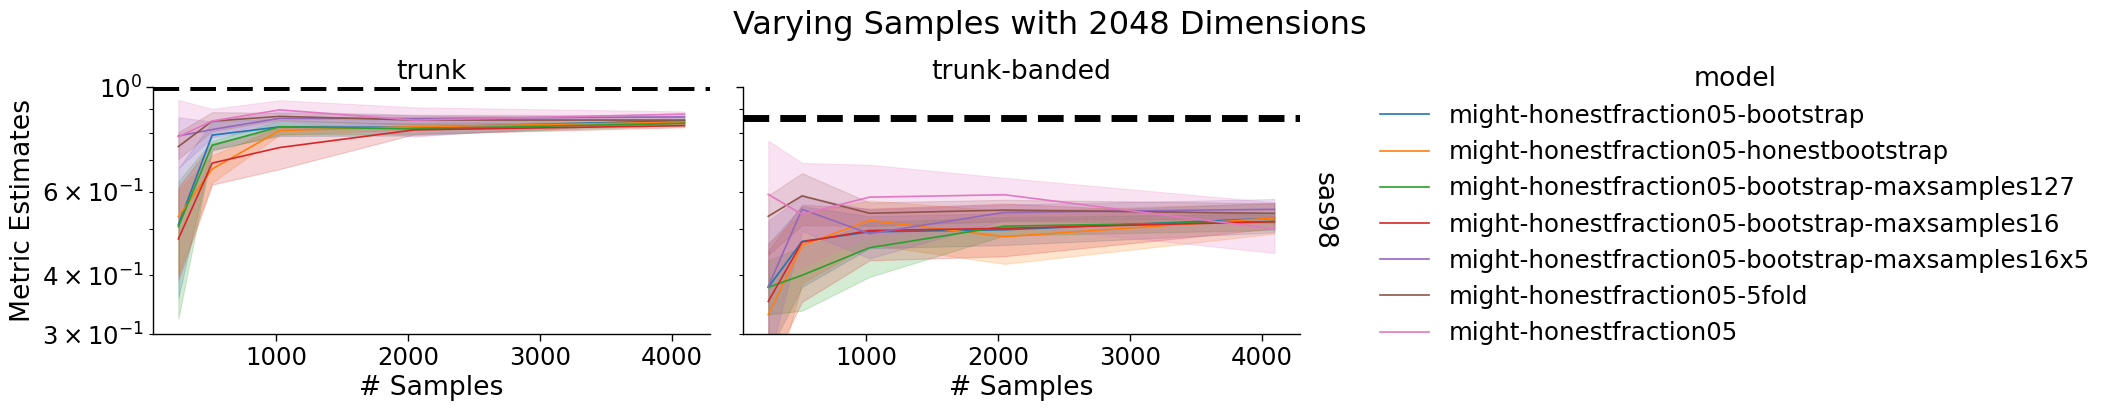

In [200]:
df = pd.DataFrame(results)
df = df[
    df["sim_type"]
    .astype(str)
    .isin(["trunk-mix", "trunk-overlap", "trunk-banded-overlap"])
    == False
]

df.drop("mi", inplace=True, axis=1)

# Melt the DataFrame to reshape it
df_melted = pd.melt(
    df,
    id_vars=["n_samples", "sim_type", "model"],
    value_vars=["sas98"],
    var_name="metric",
    value_name="metric_value",
)

# Convert "sim_type" to categorical type
df_melted["sim_type"] = df_melted["sim_type"].astype(str)
df_melted["model"] = df_melted["model"].astype(str)
# df_melted["n_dims"] = df_melted["n_dims"].astype(int)
df_melted["n_samples"] = df_melted["n_samples"].astype(int)
df_melted["metric_value"] = df_melted["metric_value"].astype(float)
# df_melted["sim_type"] = pd.Categorical(df_melted["sim_type"], categories=df["sim_type"].unique(), ordered=True)

# Now, let's create the plot using Seaborn
# sns.set(style="whitegrid")
sns.set_context("paper", font_scale=2.0)

g = sns.FacetGrid(
    df_melted,
    col="sim_type",
    row="metric",
    hue="model",
    margin_titles=True,
    height=4.0,
    aspect=1.75,
)
g.map(sns.lineplot, "n_samples", "metric_value")

for idx, sim_type in enumerate(df_melted["sim_type"].unique()):
    truth = truth_df[
        (truth_df["sim_type"] == sim_type) & (truth_df["n_dims"] == n_dims_truth)
    ]["true_sas98"]
    print(truth)
    g.axes[0][idx].axhline([truth], ls="--", linewidth=5, c="black", label="Truth")

# iterate through the axes
# for irow in range(3):
# g.axes[1][1].axhline([0.02], ls="--", linewidth=5, c="black", label="Truth")
# g.axes[1][3].axhline([0.02], ls="--", linewidth=5, c="black", label="Truth")

g.axes[0][1].set(yscale="log", ylim=[0.3, 1])
# g.axes[1][].set(yscale="log")

# Adjust the plot layout
g.set_axis_labels("# Samples", "Metric Estimates")
g.add_legend()
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.fig.suptitle("Varying Samples with 2048 Dimensions", y=1.05)
plt.show()

6    0.02
Name: true_sas98, dtype: float64
6    0.02
Name: true_sas98, dtype: float64


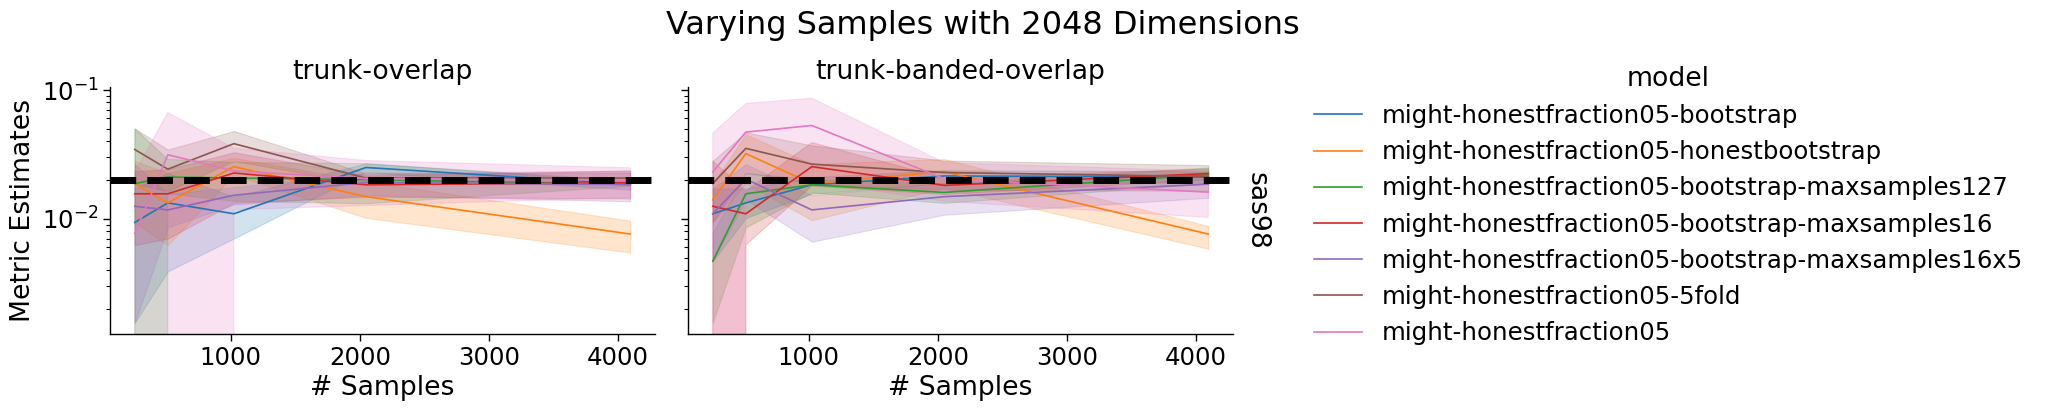

In [201]:
df = pd.DataFrame(results)
df = df[
    df["sim_type"].astype(str).isin(["trunk-mix", "trunk", "trunk-banded"]) == False
]

df.drop("mi", inplace=True, axis=1)
# df.drop("", inplace=True, axis=1)

# Melt the DataFrame to reshape it
df_melted = pd.melt(
    df,
    id_vars=["n_samples", "sim_type", "model"],
    value_vars=["sas98"],
    var_name="metric",
    value_name="metric_value",
)

# Convert "sim_type" to categorical type
df_melted["sim_type"] = df_melted["sim_type"].astype(str)
df_melted["model"] = df_melted["model"].astype(str)
# df_melted["n_dims"] = df_melted["n_dims"].astype(int)
df_melted["n_samples"] = df_melted["n_samples"].astype(int)
df_melted["metric_value"] = df_melted["metric_value"].astype(float)
# df_melted["sim_type"] = pd.Categorical(df_melted["sim_type"], categories=df["sim_type"].unique(), ordered=True)

# Now, let's create the plot using Seaborn
# sns.set(style="whitegrid")
sns.set_context("paper", font_scale=2.0)

g = sns.FacetGrid(
    df_melted,
    col="sim_type",
    row="metric",
    hue="model",
    margin_titles=True,
    height=4.0,
    aspect=1.75,
)
g.map(sns.lineplot, "n_samples", "metric_value")

# iterate through the axes
# for irow in range(3):
# g.axes[0][1].axhline([0.02], ls="--", linewidth=3, c="black", label="Truth")
# g.axes[0][0].axhline([0.02], ls="--", linewidth=3, c="black", label="Truth")

for idx, sim_type in enumerate(df_melted["sim_type"].unique()):
    truth = truth_df[
        (truth_df["sim_type"] == sim_type) & (truth_df["n_dims"] == n_dims_truth)
    ]["true_sas98"]
    print(truth)
    g.axes[0][idx].axhline([truth], ls="--", linewidth=5, c="black", label="Truth")

g.axes[0][1].set(yscale="log")
# g.axes[1][].set(yscale="log")

# Adjust the plot layout
g.set_axis_labels("# Samples", "Metric Estimates")
g.add_legend()
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.fig.suptitle("Varying Samples with 2048 Dimensions", y=1.05)
# plt.tight_layout()
plt.show()

## Varying dimensions

In [32]:
print(n_dims_list)

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]


In [202]:
# first consolidate
n_samples = 512
n_dims = 2048

results = defaultdict(list)

for model_name in [
    # "might-honestfraction05-bootstrap-x5",
    "might-honestfraction05-bootstrap",
    "might-honestfraction05-bootstrap-maxsamples127",
    "might-honestfraction05-bootstrap-maxsamples16",
    "might-honestfraction05-bootstrap-maxsamples16x5",
]:  # MODEL_NAMES.keys():
    print(model_name)
    for sim_number in range(1, 6):
        for idx in range(n_repeats):
            for n_dims in n_dims_list:
                sim_name = SIMULATIONS_NAMES[str(sim_number)]

                output_fname = (
                    root_dir
                    / "output"
                    / model_name
                    / sim_name
                    / f"{sim_name}_{n_samples}_{n_dims}_{idx}.npz"
                )
                # print(output_fname.exists())
                # Load data from the compressed npz file
                loaded_data = np.load(output_fname)

                # Extract variables with the same names
                idx = loaded_data["idx"]
                n_samples = loaded_data["n_samples"]
                n_dims = loaded_data["n_dims"]
                mi = loaded_data["mi"]
                pauc = loaded_data["pauc"]
                sas98 = loaded_data["sas98"]
                sim_name = loaded_data["sim_type"]

                results["idx"].append(idx)
                results["n_samples"].append(n_samples)
                results["n_dims"].append(n_dims)
                results["mi"].append(mi)
                results["pauc"].append(pauc)
                results["sas98"].append(sas98)
                results["sim_type"].append(sim_name)
                results["model"].append(model_name)

might-honestfraction05-bootstrap
might-honestfraction05-bootstrap-maxsamples127
might-honestfraction05-bootstrap-maxsamples16
might-honestfraction05-bootstrap-maxsamples16x5


In [203]:
for model_name in CV_MODEL_NAMES.keys():
    print(model_name)
    for sim_number in range(1, 6):
        for idx in range(n_repeats):
            for n_dims in n_dims_list:
                sim_name = SIMULATIONS_NAMES[str(sim_number)]

                output_fname = (
                    root_dir
                    / "output"
                    / model_name
                    / sim_name
                    / f"{sim_name}_{n_samples}_{n_dims}_{idx}.npz"
                )
                # print(output_fname.exists())
                # Load data from the compressed npz file
                loaded_data = np.load(output_fname)

                # Extract variables with the same names
                idx = loaded_data["idx"]
                n_samples = loaded_data["n_samples"]
                n_dims = loaded_data["n_dims"]
                mi = loaded_data["mi"]
                pauc = loaded_data["pauc"]
                sas98 = loaded_data["sas98"]
                sim_name = loaded_data["sim_type"]

                results["idx"].append(idx)
                results["n_samples"].append(n_samples)
                results["n_dims"].append(n_dims)
                results["mi"].append(mi)
                results["pauc"].append(pauc)
                results["sas98"].append(sas98)
                results["sim_type"].append(sim_name)
                results["model"].append(model_name)

might-honestfraction05-5fold


In [204]:
for model_name in NORMAL_MODEL_NAMES.keys():
    print(model_name)
    for sim_number in range(1, 6):
        for idx in range(n_repeats):
            for n_dims in n_dims_list:
                sim_name = SIMULATIONS_NAMES[str(sim_number)]

                output_fname = (
                    root_dir
                    / "output"
                    / model_name
                    / sim_name
                    / f"{sim_name}_{n_samples}_{n_dims}_{idx}.npz"
                )
                # print(output_fname.exists())
                # Load data from the compressed npz file
                loaded_data = np.load(output_fname)

                # Extract variables with the same names
                idx = loaded_data["idx"]
                n_samples = loaded_data["n_samples"]
                n_dims = loaded_data["n_dims"]
                mi = loaded_data["mi"]
                pauc = loaded_data["pauc"]
                sas98 = loaded_data["sas98"]
                sim_name = loaded_data["sim_type"]

                results["idx"].append(idx)
                results["n_samples"].append(n_samples)
                results["n_dims"].append(n_dims)
                results["mi"].append(mi)
                results["pauc"].append(pauc)
                results["sas98"].append(sas98)
                results["sim_type"].append(sim_name)
                results["model"].append(model_name)

might-honestfraction05


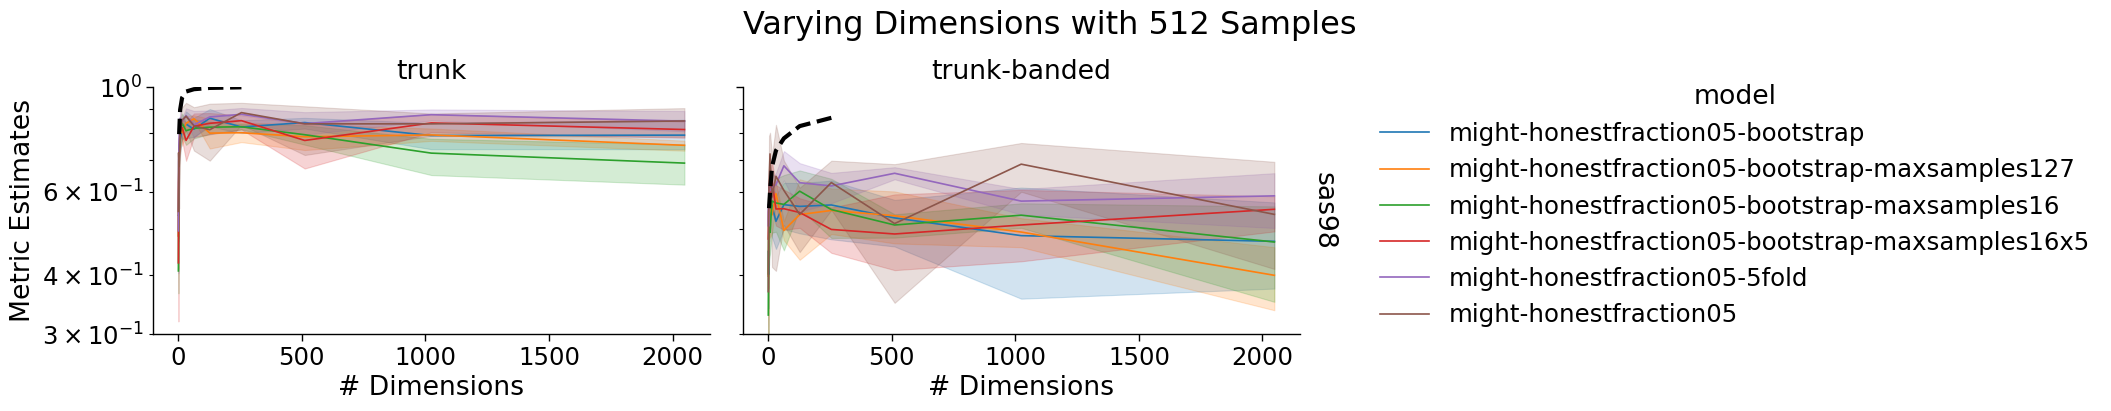

In [205]:
df = pd.DataFrame(results)
df = df[
    df["sim_type"]
    .astype(str)
    .isin(["trunk-mix", "trunk-overlap", "trunk-banded-overlap"])
    == False
]

df.drop("mi", inplace=True, axis=1)

# Melt the DataFrame to reshape it
df_melted = pd.melt(
    df,
    id_vars=["n_dims", "sim_type", "model"],
    value_vars=["sas98"],
    var_name="metric",
    value_name="metric_value",
)

# Convert "sim_type" to categorical type
df_melted["sim_type"] = df_melted["sim_type"].astype(str)
df_melted["model"] = df_melted["model"].astype(str)
df_melted["n_dims"] = df_melted["n_dims"].astype(int)
df_melted["metric_value"] = df_melted["metric_value"].astype(float)
# df_melted["sim_type"] = pd.Categorical(df_melted["sim_type"], categories=df["sim_type"].unique(), ordered=True)

# Now, let's create the plot using Seaborn
# sns.set(style="whitegrid")
sns.set_context("paper", font_scale=2.0)

g = sns.FacetGrid(
    df_melted,
    col="sim_type",
    row="metric",
    hue="model",
    margin_titles=True,
    height=4.0,
    aspect=1.75,
)
g.map(sns.lineplot, "n_dims", "metric_value")

# iterate through the axes
# for irow in range(3):
# g.axes[1][1].axhline([0.02], ls="--", linewidth=5, c="black", label="Truth")
# g.axes[1][3].axhline([0.02], ls="--", linewidth=5, c="black", label="Truth")

for idx, sim_type in enumerate(df_melted["sim_type"].unique()):
    truth_list = []
    for n_dim in truth_df["n_dims"].unique():
        truth = truth_df[
            (truth_df["sim_type"] == sim_type) & (truth_df["n_dims"] == n_dim)
        ]["true_sas98"]
        truth_list.append(truth)
    g.axes[0][idx].plot(
        truth_df["n_dims"].unique(),
        truth_list,
        color="black",
        ls="--",
        linewidth=3,
        label="Truth",
    )

g.axes[0][1].set(yscale="log", ylim=[0.3, 1])
# g.axes[1][].set(yscale="log")

# Adjust the plot layout
g.set_axis_labels("# Dimensions", "Metric Estimates")
g.add_legend()
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.fig.suptitle("Varying Dimensions with 512 Samples", y=1.05)
plt.show()

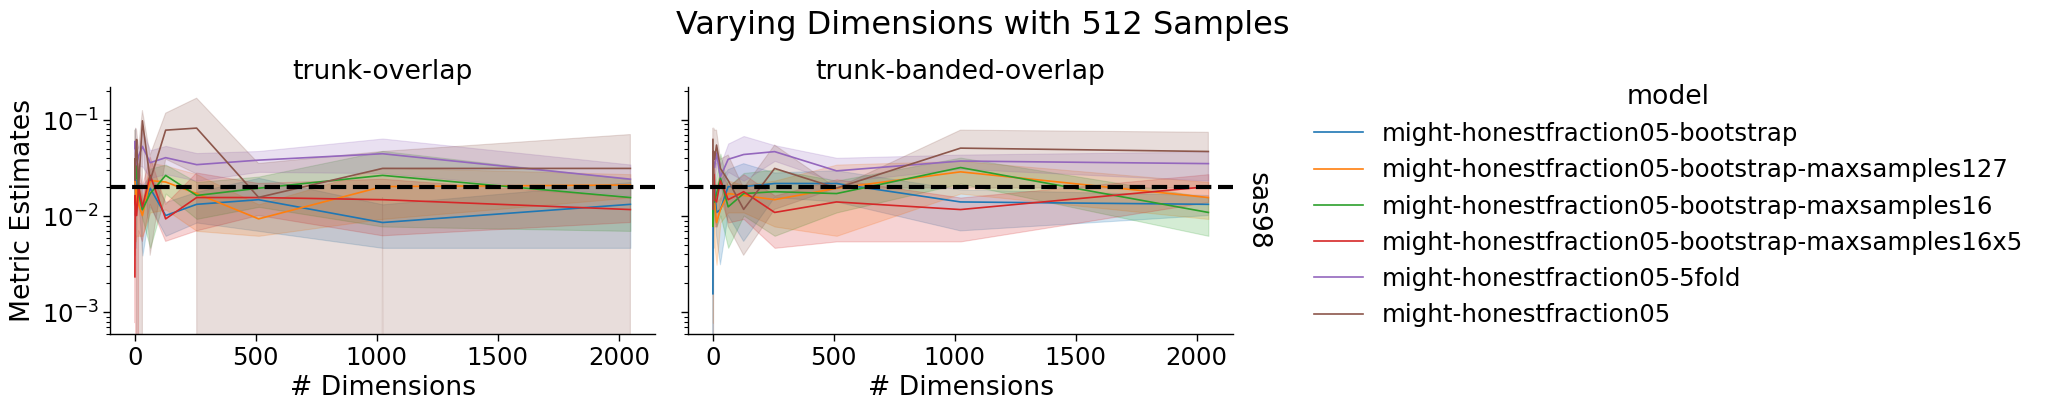

In [206]:
df = pd.DataFrame(results)
df = df[
    df["sim_type"].astype(str).isin(["trunk-mix", "trunk", "trunk-banded"]) == False
]

df.drop("mi", inplace=True, axis=1)

# Melt the DataFrame to reshape it
df_melted = pd.melt(
    df,
    id_vars=["n_dims", "sim_type", "model"],
    value_vars=["sas98"],
    var_name="metric",
    value_name="metric_value",
)

# Convert "sim_type" to categorical type
df_melted["sim_type"] = df_melted["sim_type"].astype(str)
df_melted["model"] = df_melted["model"].astype(str)
df_melted["n_dims"] = df_melted["n_dims"].astype(int)
df_melted["metric_value"] = df_melted["metric_value"].astype(float)
# df_melted["sim_type"] = pd.Categorical(df_melted["sim_type"], categories=df["sim_type"].unique(), ordered=True)

# Now, let's create the plot using Seaborn
# sns.set(style="whitegrid")
sns.set_context("paper", font_scale=2.0)

g = sns.FacetGrid(
    df_melted,
    col="sim_type",
    row="metric",
    hue="model",
    margin_titles=True,
    height=4.0,
    aspect=1.75,
)
g.map(sns.lineplot, "n_dims", "metric_value")

# iterate through the axes
# for irow in range(3):
# g.axes[0][1].axhline([0.02], ls="--", linewidth=3, c="black", label="Truth")
# g.axes[0][0].axhline([0.02], ls="--", linewidth=3, c="black", label="Truth")
for idx, sim_type in enumerate(df_melted["sim_type"].unique()):
    truth_list = []
    for n_dim in truth_df["n_dims"].unique():
        truth = truth_df[
            (truth_df["sim_type"] == sim_type) & (truth_df["n_dims"] == n_dim)
        ]["true_sas98"]
        truth_list.append(truth)
    g.axes[0][idx].axhline(
        np.unique(truth_list), color="black", ls="--", linewidth=3, label="Truth"
    )


# g.axes[1][1].set(yscale="log", ylim=[0.3, 1])
g.axes[0][0].set(yscale="log")

# Adjust the plot layout
g.set_axis_labels("# Dimensions", "Metric Estimates")
g.add_legend()
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.fig.suptitle("Varying Dimensions with 512 Samples", y=1.05)
plt.show()

## New Plots

In [253]:
# first consolidate
n_samples = 512
n_dims_ = 4096
n_samples_ = 2048
n_dims = 2048
results = defaultdict(list)

n_samples = 524
# for sim_number in range(1, 6):
#     for idx in range(n_repeats):
#         for n_samples in n_samples_list:
#             sim_name = SIMULATIONS_NAMES[str(sim_number)]

#             output_fname = (
#                 root_dir
#                 / "output"
#                 / "varying-samples-sample-per-tree"
#                 / sim_name
#                 / f"{sim_name}_{n_samples}_{n_dims}_{idx}.npz"
#             )
#             # Load data from the compressed npz file
#             loaded_data = np.load(output_fname)

#             # Extract variables with the same names
#             idx = loaded_data["idx"]
#             n_samples = loaded_data["n_samples"]
#             n_dims = loaded_data["n_dims"]
#             mi = loaded_data["mi"]
#             pauc = loaded_data["pauc"]
#             sas98 = loaded_data["sas98"]
#             sim_name = loaded_data["sim_type"]

#             results["idx"].append(idx)
#             results["n_samples"].append(n_samples)
#             results["n_dims"].append(n_dims)
#             results["mi"].append(mi)
#             results["pauc"].append(pauc)
#             results["sas98"].append(sas98)
#             results["sim_type"].append(sim_name)
#             results["model"].append("MIGHT-sample-per-tree")

for sim_number in range(1, 6):
    for idx in range(n_repeats):
        for n_samples in n_samples_list:
            sim_name = SIMULATIONS_NAMES[str(sim_number)]

            output_fname = (
                root_dir
                / "output"
                / "varying-samples"
                / sim_name
                / f"{sim_name}_{n_samples}_{n_dims}_{idx}.npz"
            )
            # Load data from the compressed npz file
            loaded_data = np.load(output_fname)

            # Extract variables with the same names
            idx = loaded_data["idx"]
            n_samples = loaded_data["n_samples"]
            n_dims = loaded_data["n_dims"]
            mi = loaded_data["mi"]
            pauc = loaded_data["pauc"]
            sas98 = loaded_data["sas98"]
            sim_name = loaded_data["sim_type"]

            results["idx"].append(idx)
            results["n_samples"].append(n_samples)
            results["n_dims"].append(n_dims)
            results["mi"].append(mi)
            results["pauc"].append(pauc)
            results["sas98"].append(sas98)
            results["sim_type"].append(sim_name)
            results["model"].append("MIGHT")

# for sim_number in range(1, 6):
#     for idx in range(n_repeats):
#         for n_samples in n_samples_list:
#             sim_name = SIMULATIONS_NAMES[str(sim_number)]

#             output_fname = (
#                 root_dir
#                 / "output"
#                 / "varying-samples-2500-trees"
#                 / sim_name
#                 / f"{sim_name}_{n_samples}_{n_dims}_{idx}.npz"
#             )
#             # Load data from the compressed npz file
#             loaded_data = np.load(output_fname)

#             # Extract variables with the same names
#             idx = loaded_data["idx"]
#             n_samples = loaded_data["n_samples"]
#             n_dims = loaded_data["n_dims"]
#             mi = loaded_data["mi"]
#             pauc = loaded_data["pauc"]
#             sas98 = loaded_data["sas98"]
#             sim_name = loaded_data["sim_type"]

#             results["idx"].append(idx)
#             results["n_samples"].append(n_samples)
#             results["n_dims"].append(n_dims)
#             results["mi"].append(mi)
#             results["pauc"].append(pauc)
#             results["sas98"].append(sas98)
#             results["sim_type"].append(sim_name)
#             results["model"].append("MIGHT-5x")


n_samples = 512


for sim_number in range(1, 6):
    for idx in range(n_repeats):
        for n_samples in n_samples_list:
            sim_name = SIMULATIONS_NAMES[str(sim_number)]

            output_fname = (
                root_dir
                / "output"
                / "varying-samples-5fold"
                / sim_name
                / f"{sim_name}_{n_samples}_{n_dims}_{idx}.npz"
            )
            # Load data from the compressed npz file
            loaded_data = np.load(output_fname)

            # Extract variables with the same names
            idx = loaded_data["idx"]
            n_samples = loaded_data["n_samples"]
            n_dims = loaded_data["n_dims"]
            mi = loaded_data["mi"]
            pauc = loaded_data["pauc"]
            sas98 = loaded_data["sas98"]
            sim_name = loaded_data["sim_type"]

            results["idx"].append(idx)
            results["n_samples"].append(n_samples)
            results["n_dims"].append(n_dims)
            results["mi"].append(mi)
            results["pauc"].append(pauc)
            results["sas98"].append(sas98)
            results["sim_type"].append(sim_name)
            results["model"].append("MIGHT-5fold")


for sim_number in range(1, 6):
    for idx in range(n_repeats):
        for n_samples in n_samples_list:
            sim_name = SIMULATIONS_NAMES[str(sim_number)]

            output_fname = (
                root_dir
                / "output"
                / "varying-samples-5fold-with-bootstrap"
                / sim_name
                / f"{sim_name}_{n_samples}_{n_dims}_{idx}.npz"
            )
            # Load data from the compressed npz file
            loaded_data = np.load(output_fname)

            # Extract variables with the same names
            idx = loaded_data["idx"]
            n_samples = loaded_data["n_samples"]
            n_dims = loaded_data["n_dims"]
            mi = loaded_data["mi"]
            pauc = loaded_data["pauc"]
            sas98 = loaded_data["sas98"]
            sim_name = loaded_data["sim_type"]

            results["idx"].append(idx)
            results["n_samples"].append(n_samples)
            results["n_dims"].append(n_dims)
            results["mi"].append(mi)
            results["pauc"].append(pauc)
            results["sas98"].append(sas98)
            results["sim_type"].append(sim_name)
            results["model"].append("MIGHT-5fold-withbootstrap")

# for sim_number in range(1, 6):
#     for idx in range(n_repeats):
#         for n_samples in n_samples_list:
#             sim_name = SIMULATIONS_NAMES[str(sim_number)]

#             output_fname = (
#                 root_dir
#                 / "output"
#                 / "varying-samples-sample-per-tree-bootstrap"
#                 / sim_name
#                 / f"{sim_name}_{n_samples}_{n_dims}_{idx}.npz"
#             )
#             # Load data from the compressed npz file
#             loaded_data = np.load(output_fname)

#             # Extract variables with the same names
#             idx = loaded_data["idx"]
#             n_samples = loaded_data["n_samples"]
#             n_dims = loaded_data["n_dims"]
#             mi = loaded_data["mi"]
#             pauc = loaded_data["pauc"]
#             sas98 = loaded_data["sas98"]
#             sim_name = loaded_data["sim_type"]

#             results["idx"].append(idx)
#             results["n_samples"].append(n_samples)
#             results["n_dims"].append(n_dims)
#             results["mi"].append(mi)
#             results["pauc"].append(pauc)
#             results["sas98"].append(sas98)
#             results["sim_type"].append(sim_name)
#             results["model"].append("MIGHT-sample-per-tree-bootstrap")


for sim_number in range(1, 6):
    for idx in range(n_repeats):
        for n_samples in n_samples_list:
            sim_name = SIMULATIONS_NAMES[str(sim_number)]

            output_fname = (
                root_dir
                / "output"
                / "varying-samples-sample-per-tree-bootstrapv2"
                / sim_name
                / f"{sim_name}_{n_samples}_{n_dims}_{idx}.npz"
            )
            # Load data from the compressed npz file
            loaded_data = np.load(output_fname)

            # Extract variables with the same names
            idx = loaded_data["idx"]
            n_samples = loaded_data["n_samples"]
            n_dims = loaded_data["n_dims"]
            mi = loaded_data["mi"]
            pauc = loaded_data["pauc"]
            sas98 = loaded_data["sas98"]
            sim_name = loaded_data["sim_type"]

            results["idx"].append(idx)
            results["n_samples"].append(n_samples)
            results["n_dims"].append(n_dims)
            results["mi"].append(mi)
            results["pauc"].append(pauc)
            results["sas98"].append(sas98)
            results["sim_type"].append(sim_name)
            results["model"].append("MIGHT-sample-per-tree-bootstrapv2")


# for sim_number in range(1, 6):
#     for idx in range(n_repeats):
#         for n_samples in n_samples_list:
#             sim_name = SIMULATIONS_NAMES[str(sim_number)]

#             output_fname = (
#                 root_dir
#                 / "output"
#                 / "varying-samples-sample-per-tree-bootstrap-with-stratify"
#                 / sim_name
#                 / f"{sim_name}_{n_samples}_{n_dims}_{idx}.npz"
#             )
#             # Load data from the compressed npz file
#             loaded_data = np.load(output_fname)

#             # Extract variables with the same names
#             idx = loaded_data["idx"]
#             n_samples = loaded_data["n_samples"]
#             n_dims = loaded_data["n_dims"]
#             mi = loaded_data["mi"]
#             pauc = loaded_data["pauc"]
#             sas98 = loaded_data["sas98"]
#             sim_name = loaded_data["sim_type"]

#             results["idx"].append(idx)
#             results["n_samples"].append(n_samples)
#             results["n_dims"].append(n_dims)
#             results["mi"].append(mi)
#             results["pauc"].append(pauc)
#             results["sas98"].append(sas98)
#             results["sim_type"].append(sim_name)
#             results["model"].append("MIGHT-sample-per-tree-bootstrap-with-stratify")

# n_samples_list = [2**x for x in range(8, 13)]
# for sim_number in range(1, 6):
#     for idx in range(n_repeats):
#         for n_samples in n_samples_list:
#             sim_name = SIMULATIONS_NAMES[str(sim_number)]

#             output_fname = (
#                 root_dir
#                 / "output"
#                 / "varying-samples-sample-per-tree-bootstrap-with-stratify-bootstrap-forest"
#                 / sim_name
#                 / f"{sim_name}_{n_samples}_{n_dims}_{idx}.npz"
#             )
#             # Load data from the compressed npz file
#             loaded_data = np.load(output_fname)

#             # Extract variables with the same names
#             idx = loaded_data["idx"]
#             n_samples = loaded_data["n_samples"]
#             n_dims = loaded_data["n_dims"]
#             mi = loaded_data["mi"]
#             pauc = loaded_data["pauc"]
#             sas98 = loaded_data["sas98"]
#             sim_name = loaded_data["sim_type"]

#             results["idx"].append(idx)
#             results["n_samples"].append(n_samples)
#             results["n_dims"].append(n_dims)
#             results["mi"].append(mi)
#             results["pauc"].append(pauc)
#             results["sas98"].append(sas98)
#             results["sim_type"].append(sim_name)
#             results["model"].append(
#                 "MIGHT-sample-per-tree-bootstrap-with-stratify-bootstrap-forest"
#             )


for sim_number in range(1, 6):
    for idx in range(n_repeats):
        for n_samples in n_samples_list:
            sim_name = SIMULATIONS_NAMES[str(sim_number)]

            output_fname = (
                root_dir
                / "output"
                / "bootstrapv4"
                / sim_name
                / f"{sim_name}_{n_samples}_{n_dims}_{idx}.npz"
            )
            # Load data from the compressed npz file
            loaded_data = np.load(output_fname)

            # Extract variables with the same names
            idx = loaded_data["idx"]
            n_samples = loaded_data["n_samples"]
            n_dims = loaded_data["n_dims"]
            mi = loaded_data["mi"]
            pauc = loaded_data["pauc"]
            sas98 = loaded_data["sas98"]
            sim_name = loaded_data["sim_type"]

            results["idx"].append(idx)
            results["n_samples"].append(n_samples)
            results["n_dims"].append(n_dims)
            results["mi"].append(mi)
            results["pauc"].append(pauc)
            results["sas98"].append(sas98)
            results["sim_type"].append(sim_name)
            results["model"].append("MIGHT-bootstrapv4")


for sim_number in range(1, 6):
    for idx in range(n_repeats):
        for n_samples in n_samples_list:
            sim_name = SIMULATIONS_NAMES[str(sim_number)]

            output_fname = (
                root_dir
                / "output"
                / "bootstrapv4x5"
                / sim_name
                / f"{sim_name}_{n_samples}_{n_dims}_{idx}.npz"
            )
            # Load data from the compressed npz file
            loaded_data = np.load(output_fname)

            # Extract variables with the same names
            idx = loaded_data["idx"]
            n_samples = loaded_data["n_samples"]
            n_dims = loaded_data["n_dims"]
            mi = loaded_data["mi"]
            pauc = loaded_data["pauc"]
            sas98 = loaded_data["sas98"]
            sim_name = loaded_data["sim_type"]

            results["idx"].append(idx)
            results["n_samples"].append(n_samples)
            results["n_dims"].append(n_dims)
            results["mi"].append(mi)
            results["pauc"].append(pauc)
            results["sas98"].append(sas98)
            results["sim_type"].append(sim_name)
            results["model"].append("MIGHT-bootstrapv4x5")

for sim_number in range(1, 6):
    for idx in range(n_repeats):
        for n_samples in n_samples_list[2:]:
            sim_name = SIMULATIONS_NAMES[str(sim_number)]

            output_fname = (
                root_dir
                / "output"
                / "bootstrapv3x5"
                / sim_name
                / f"{sim_name}_{n_samples}_{n_dims}_{idx}.npz"
            )
            # Load data from the compressed npz file
            loaded_data = np.load(output_fname)

            # Extract variables with the same names
            idx = loaded_data["idx"]
            n_samples = loaded_data["n_samples"]
            n_dims = loaded_data["n_dims"]
            mi = loaded_data["mi"]
            pauc = loaded_data["pauc"]
            sas98 = loaded_data["sas98"]
            sim_name = loaded_data["sim_type"]

            results["idx"].append(idx)
            results["n_samples"].append(n_samples)
            results["n_dims"].append(n_dims)
            results["mi"].append(mi)
            results["pauc"].append(pauc)
            results["sas98"].append(sas98)
            results["sim_type"].append(sim_name)
            results["model"].append("MIGHT-bootstrapv3x5")

for sim_number in range(1, 6):
    for idx in range(n_repeats):
        for n_samples in n_samples_list:
            sim_name = SIMULATIONS_NAMES[str(sim_number)]

            output_fname = (
                root_dir
                / "output"
                / "bootstrapv4_with_75structure"
                / sim_name
                / f"{sim_name}_{n_samples}_{n_dims}_{idx}.npz"
            )
            # Load data from the compressed npz file
            loaded_data = np.load(output_fname)

            # Extract variables with the same names
            idx = loaded_data["idx"]
            n_samples = loaded_data["n_samples"]
            n_dims = loaded_data["n_dims"]
            mi = loaded_data["mi"]
            pauc = loaded_data["pauc"]
            sas98 = loaded_data["sas98"]
            sim_name = loaded_data["sim_type"]

            results["idx"].append(idx)
            results["n_samples"].append(n_samples)
            results["n_dims"].append(n_dims)
            results["mi"].append(mi)
            results["pauc"].append(pauc)
            results["sas98"].append(sas98)
            results["sim_type"].append(sim_name)
            results["model"].append("MIGHT-bootstrapv4_with_75structure")


for sim_number in range(1, 6):
    for idx in range(n_repeats):
        for n_samples in n_samples_list:
            sim_name = SIMULATIONS_NAMES[str(sim_number)]

            output_fname = (
                root_dir
                / "output"
                / "varying-samples-sample-per-tree-bootstrapv3"
                / sim_name
                / f"{sim_name}_{n_samples}_{n_dims}_{idx}.npz"
            )
            # Load data from the compressed npz file
            loaded_data = np.load(output_fname)

            # Extract variables with the same names
            idx = loaded_data["idx"]
            n_samples = loaded_data["n_samples"]
            n_dims = loaded_data["n_dims"]
            mi = loaded_data["mi"]
            pauc = loaded_data["pauc"]
            sas98 = loaded_data["sas98"]
            sim_name = loaded_data["sim_type"]

            results["idx"].append(idx)
            results["n_samples"].append(n_samples)
            results["n_dims"].append(n_dims)
            results["mi"].append(mi)
            results["pauc"].append(pauc)
            results["sas98"].append(sas98)
            results["sim_type"].append(sim_name)
            results["model"].append("MIGHT-sample-per-tree-bootstrapv3")


# for sim_number in range(1, 6):
#     for idx in range(n_repeats):
#         for n_samples in n_samples_list:
#             sim_name = SIMULATIONS_NAMES[str(sim_number)]

#             output_fname = (
#                 root_dir
#                 / "output"
#                 / "varying-samples-sample-per-tree-bootstrapv3-5"
#                 / sim_name
#                 / f"{sim_name}_{n_samples}_{n_dims}_{idx}.npz"
#             )
#             # Load data from the compressed npz file
#             loaded_data = np.load(output_fname)

#             # Extract variables with the same names
#             idx = loaded_data["idx"]
#             n_samples = loaded_data["n_samples"]
#             n_dims = loaded_data["n_dims"]
#             mi = loaded_data["mi"]
#             pauc = loaded_data["pauc"]
#             sas98 = loaded_data["sas98"]
#             sim_name = loaded_data["sim_type"]

#             results["idx"].append(idx)
#             results["n_samples"].append(n_samples)
#             results["n_dims"].append(n_dims)
#             results["mi"].append(mi)
#             results["pauc"].append(pauc)
#             results["sas98"].append(sas98)
#             results["sim_type"].append(sim_name)
#             results["model"].append("MIGHT-sample-per-tree-bootstrapv3.5")


# for sim_number in range(1, 6):
#     for idx in range(n_repeats):
#         for n_samples in n_samples_list:
#             sim_name = SIMULATIONS_NAMES[str(sim_number)]

#             output_fname = (
#                 root_dir
#                 / "output"
#                 / "varying-samples-sample-per-tree-bootstrapv5"
#                 / sim_name
#                 / f"{sim_name}_{n_samples}_{n_dims}_{idx}.npz"
#             )
#             # Load data from the compressed npz file
#             loaded_data = np.load(output_fname)

#             # Extract variables with the same names
#             idx = loaded_data["idx"]
#             n_samples = loaded_data["n_samples"]
#             n_dims = loaded_data["n_dims"]
#             mi = loaded_data["mi"]
#             pauc = loaded_data["pauc"]
#             sas98 = loaded_data["sas98"]
#             sim_name = loaded_data["sim_type"]

#             results["idx"].append(idx)
#             results["n_samples"].append(n_samples)
#             results["n_dims"].append(n_dims)
#             results["mi"].append(mi)
#             results["pauc"].append(pauc)
#             results["sas98"].append(sas98)
#             results["sim_type"].append(sim_name)
#             results["model"].append("MIGHT-sample-per-tree-bootstrapv5")

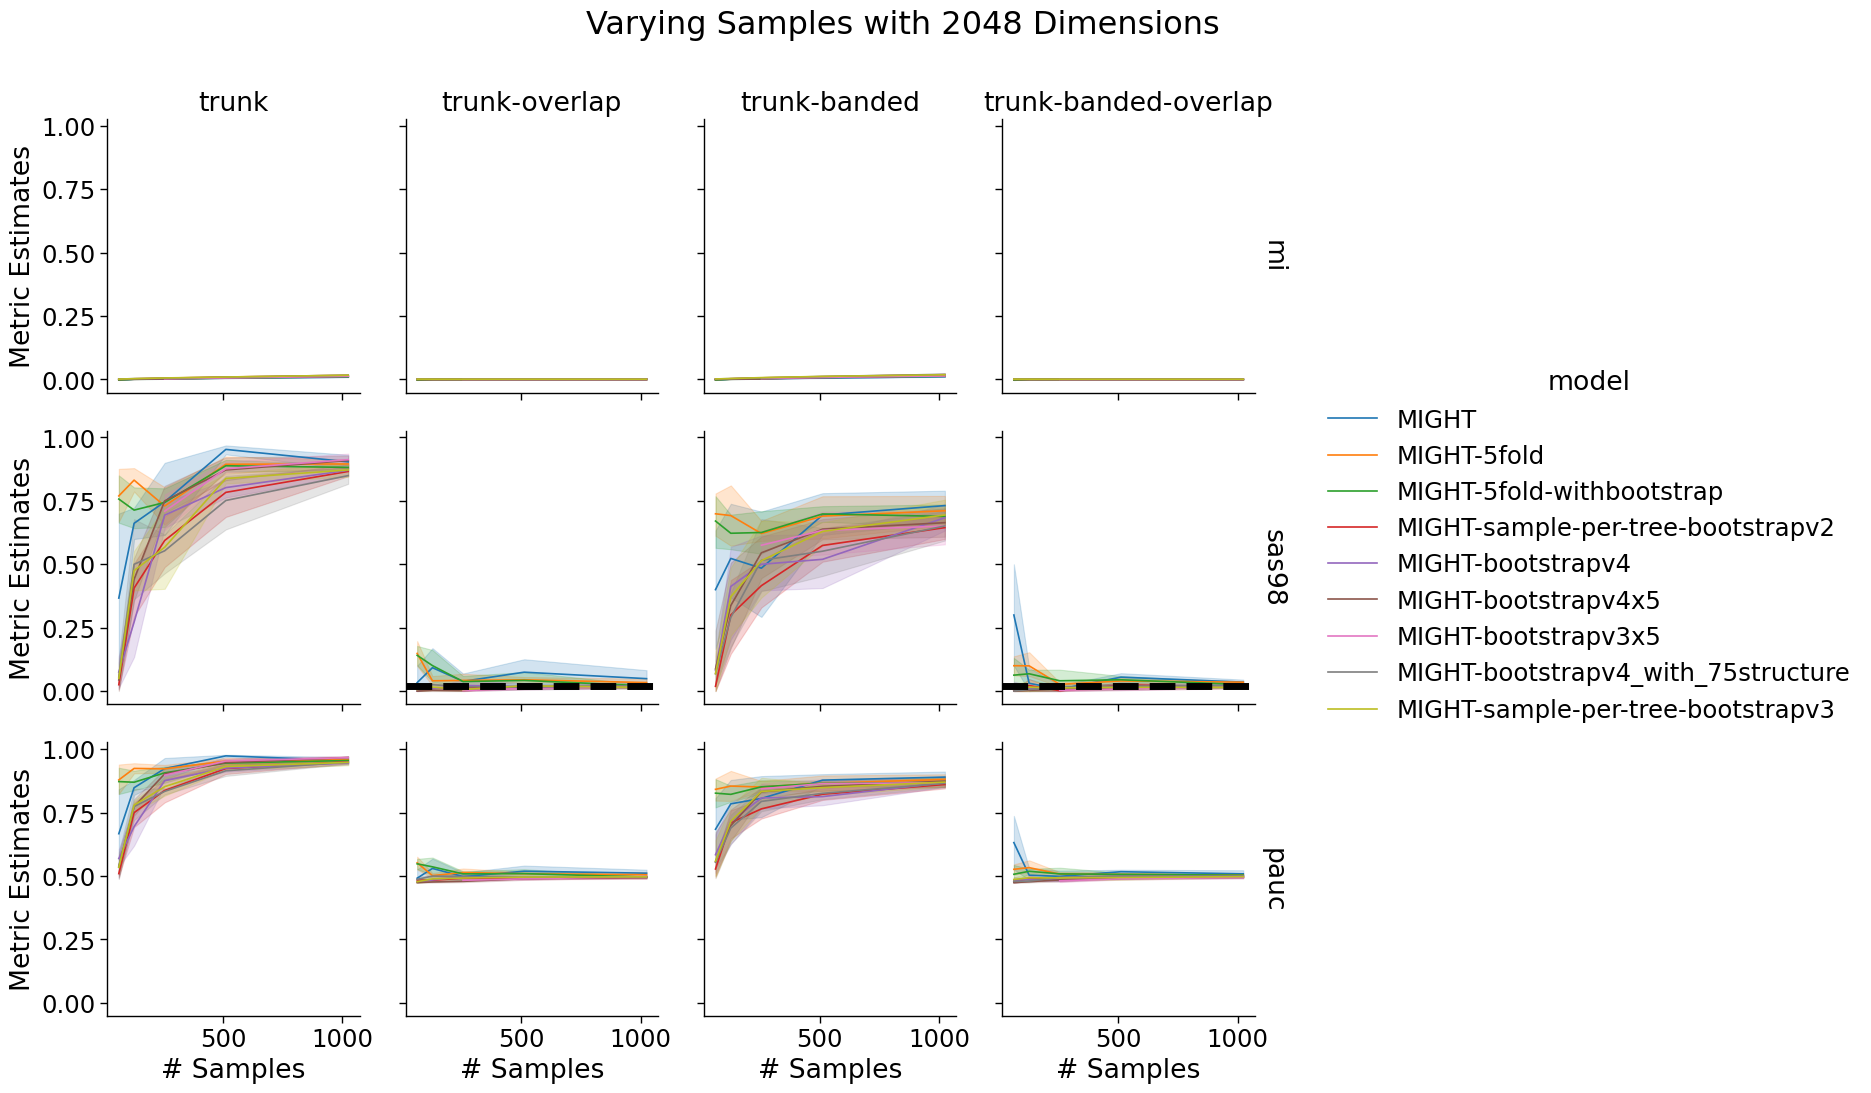

In [254]:
df = pd.DataFrame(results)

df = df[df["sim_type"] != "trunk-mix"]

# Melt the DataFrame to reshape it
df_melted = pd.melt(
    df,
    id_vars=["n_samples", "sim_type", "model"],
    value_vars=["mi", "sas98", "pauc"],
    var_name="metric",
    value_name="metric_value",
)

# Convert "sim_type" to categorical type
df_melted["sim_type"] = df_melted["sim_type"].astype(str)
df_melted["model"] = df_melted["model"].astype(str)
df_melted["n_samples"] = df_melted["n_samples"].astype(int)
df_melted["metric_value"] = df_melted["metric_value"].astype(float)
# df_melted["sim_type"] = pd.Categorical(df_melted["sim_type"], categories=df["sim_type"].unique(), ordered=True)

# Now, let's create the plot using Seaborn
sns.set_context("paper", font_scale=2.0)

g = sns.FacetGrid(
    df_melted,
    col="sim_type",
    row="metric",
    hue="model",
    margin_titles=True,
    height=3.5,
    aspect=1.0,
)
g.map(sns.lineplot, "n_samples", "metric_value")

# iterate through the axes
# for irow in range(3):
g.axes[1][1].axhline([0.02], ls="--", linewidth=5, c="black", label="Truth")
g.axes[1][3].axhline([0.02], ls="--", linewidth=5, c="black", label="Truth")

# g.axes[1][1].set(yscale="log")
# g.axes[1][3].set(yscale="log")

# Adjust the plot layout
g.set_axis_labels("# Samples", "Metric Estimates")

g.add_legend()
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.fig.suptitle("Varying Samples with 2048 Dimensions", y=1.05)
plt.show()

In [255]:
print("RESULTS FOR MIGHT-sample-per-tree-bootstrapv3:\n")
# Filter the DataFrame for sim_type=='trunk_overlap' and metric=='sas98'
filtered_df = df_melted[
    (df_melted["sim_type"] == "trunk-overlap")
    & (df_melted["metric"] == "sas98")
    & (df_melted["model"] == "MIGHT-sample-per-tree-bootstrapv3")
]

# Group by 'n_samples' and calculate mean and std
grouped_df = filtered_df.groupby("n_samples")["metric_value"].agg(["mean", "std"])

# Format the values to display up to 3 decimal places
grouped_df["mean"] = grouped_df["mean"].apply(lambda x: format(x, ".3f"))
grouped_df["std"] = grouped_df["std"].apply(lambda x: format(x, ".3f"))

# Print the results
print("Mean and Standard Deviation SAS98 for sim_type='trunk_overlap' by Sample Size:")
for sample_size, values in grouped_df.iterrows():
    print(f"S@S98 for Sample Size: {sample_size}: {values['mean']} +/- {values['std']}")


# Filter the DataFrame for sim_type=='trunk_overlap' and metric=='sas98'
filtered_df = df_melted[
    (df_melted["sim_type"] == "trunk-banded-overlap")
    & (df_melted["metric"] == "sas98")
    & (df_melted["model"] == "MIGHT-sample-per-tree-bootstrapv3")
]

# Group by 'n_samples' and calculate mean and std
grouped_df = filtered_df.groupby("n_samples")["metric_value"].agg(["mean", "std"])

# Format the values to display up to 3 decimal places
grouped_df["mean"] = grouped_df["mean"].apply(lambda x: format(x, ".3f"))
grouped_df["std"] = grouped_df["std"].apply(lambda x: format(x, ".3f"))

# Print the results
print(
    "Mean and Standard Deviation SAS98 for sim_type='trunk-banded_overlap' by Sample Size:"
)
for sample_size, values in grouped_df.iterrows():
    print(f"S@S98 for Sample Size: {sample_size}: {values['mean']} +/- {values['std']}")

RESULTS FOR MIGHT-sample-per-tree-bootstrapv3:

Mean and Standard Deviation SAS98 for sim_type='trunk_overlap' by Sample Size:
S@S98 for Sample Size: 64: 0.006 +/- 0.014
S@S98 for Sample Size: 128: 0.016 +/- 0.019
S@S98 for Sample Size: 256: 0.006 +/- 0.007
S@S98 for Sample Size: 512: 0.021 +/- 0.006
S@S98 for Sample Size: 1024: 0.014 +/- 0.007
Mean and Standard Deviation SAS98 for sim_type='trunk-banded_overlap' by Sample Size:
S@S98 for Sample Size: 64: 0.013 +/- 0.017
S@S98 for Sample Size: 128: 0.016 +/- 0.027
S@S98 for Sample Size: 256: 0.013 +/- 0.013
S@S98 for Sample Size: 512: 0.015 +/- 0.008
S@S98 for Sample Size: 1024: 0.015 +/- 0.005


In [256]:
print("RESULTS FOR MIGHT-sample-per-tree-bootstrapv3x5:\n")
# Filter the DataFrame for sim_type=='trunk_overlap' and metric=='sas98'
filtered_df = df_melted[
    (df_melted["sim_type"] == "trunk-overlap")
    & (df_melted["metric"] == "sas98")
    & (df_melted["model"] == "MIGHT-bootstrapv3x5")
]

# Group by 'n_samples' and calculate mean and std
grouped_df = filtered_df.groupby("n_samples")["metric_value"].agg(["mean", "std"])

# Format the values to display up to 3 decimal places
grouped_df["mean"] = grouped_df["mean"].apply(lambda x: format(x, ".3f"))
grouped_df["std"] = grouped_df["std"].apply(lambda x: format(x, ".3f"))

# Print the results
print("Mean and Standard Deviation SAS98 for sim_type='trunk_overlap' by Sample Size:")
for sample_size, values in grouped_df.iterrows():
    print(f"S@S98 for Sample Size: {sample_size}: {values['mean']} +/- {values['std']}")


# Filter the DataFrame for sim_type=='trunk_overlap' and metric=='sas98'
filtered_df = df_melted[
    (df_melted["sim_type"] == "trunk-banded-overlap")
    & (df_melted["metric"] == "sas98")
    & (df_melted["model"] == "MIGHT-bootstrapv3x5")
]

# Group by 'n_samples' and calculate mean and std
grouped_df = filtered_df.groupby("n_samples")["metric_value"].agg(["mean", "std"])

# Format the values to display up to 3 decimal places
grouped_df["mean"] = grouped_df["mean"].apply(lambda x: format(x, ".3f"))
grouped_df["std"] = grouped_df["std"].apply(lambda x: format(x, ".3f"))

# Print the results
print(
    "Mean and Standard Deviation SAS98 for sim_type='trunk-banded_overlap' by Sample Size:"
)
for sample_size, values in grouped_df.iterrows():
    print(f"S@S98 for Sample Size: {sample_size}: {values['mean']} +/- {values['std']}")

RESULTS FOR MIGHT-sample-per-tree-bootstrapv3x5:

Mean and Standard Deviation SAS98 for sim_type='trunk_overlap' by Sample Size:
S@S98 for Sample Size: 256: 0.002 +/- 0.003
S@S98 for Sample Size: 512: 0.011 +/- 0.005
S@S98 for Sample Size: 1024: 0.018 +/- 0.006
Mean and Standard Deviation SAS98 for sim_type='trunk-banded_overlap' by Sample Size:
S@S98 for Sample Size: 256: 0.003 +/- 0.004
S@S98 for Sample Size: 512: 0.009 +/- 0.008
S@S98 for Sample Size: 1024: 0.017 +/- 0.009


In [236]:
print("RESULTS FOR MIGHT-sample-per-tree-bootstrapv4_075:\n")
# Filter the DataFrame for sim_type=='trunk_overlap' and metric=='sas98'
filtered_df = df_melted[
    (df_melted["sim_type"] == "trunk-overlap")
    & (df_melted["metric"] == "sas98")
    & (df_melted["model"] == "MIGHT-bootstrapv4_with_75structure")
]

# Group by 'n_samples' and calculate mean and std
grouped_df = filtered_df.groupby("n_samples")["metric_value"].agg(["mean", "std"])

# Format the values to display up to 3 decimal places
grouped_df["mean"] = grouped_df["mean"].apply(lambda x: format(x, ".3f"))
grouped_df["std"] = grouped_df["std"].apply(lambda x: format(x, ".3f"))

# Print the results
print("Mean and Standard Deviation SAS98 for sim_type='trunk_overlap' by Sample Size:")
for sample_size, values in grouped_df.iterrows():
    print(f"S@S98 for Sample Size: {sample_size}: {values['mean']} +/- {values['std']}")


# Filter the DataFrame for sim_type=='trunk_overlap' and metric=='sas98'
filtered_df = df_melted[
    (df_melted["sim_type"] == "trunk-banded-overlap")
    & (df_melted["metric"] == "sas98")
    & (df_melted["model"] == "MIGHT-bootstrapv4_with_75structure")
]

# Group by 'n_samples' and calculate mean and std
grouped_df = filtered_df.groupby("n_samples")["metric_value"].agg(["mean", "std"])

# Format the values to display up to 3 decimal places
grouped_df["mean"] = grouped_df["mean"].apply(lambda x: format(x, ".3f"))
grouped_df["std"] = grouped_df["std"].apply(lambda x: format(x, ".3f"))

# Print the results
print(
    "Mean and Standard Deviation SAS98 for sim_type='trunk-banded_overlap' by Sample Size:"
)
for sample_size, values in grouped_df.iterrows():
    print(f"S@S98 for Sample Size: {sample_size}: {values['mean']} +/- {values['std']}")

RESULTS FOR MIGHT-sample-per-tree-bootstrapv4_075:

Mean and Standard Deviation SAS98 for sim_type='trunk_overlap' by Sample Size:
S@S98 for Sample Size: 64: 0.013 +/- 0.017
S@S98 for Sample Size: 128: 0.025 +/- 0.009
S@S98 for Sample Size: 256: 0.017 +/- 0.012
S@S98 for Sample Size: 512: 0.016 +/- 0.007
S@S98 for Sample Size: 1024: 0.021 +/- 0.018
Mean and Standard Deviation SAS98 for sim_type='trunk-banded_overlap' by Sample Size:
S@S98 for Sample Size: 64: 0.000 +/- 0.000
S@S98 for Sample Size: 128: 0.006 +/- 0.009
S@S98 for Sample Size: 256: 0.016 +/- 0.015
S@S98 for Sample Size: 512: 0.020 +/- 0.012
S@S98 for Sample Size: 1024: 0.021 +/- 0.009


In [ ]:
print("RESULTS FOR MIGHT-sample-per-tree-bootstrapv4:\n")
# Filter the DataFrame for sim_type=='trunk_overlap' and metric=='sas98'
filtered_df = df_melted[
    (df_melted["sim_type"] == "trunk-overlap")
    & (df_melted["metric"] == "sas98")
    & (df_melted["model"] == "MIGHT-bootstrapv4")
]

# Group by 'n_samples' and calculate mean and std
grouped_df = filtered_df.groupby("n_samples")["metric_value"].agg(["mean", "std"])

# Format the values to display up to 3 decimal places
grouped_df["mean"] = grouped_df["mean"].apply(lambda x: format(x, ".3f"))
grouped_df["std"] = grouped_df["std"].apply(lambda x: format(x, ".3f"))

# Print the results
print("Mean and Standard Deviation SAS98 for sim_type='trunk_overlap' by Sample Size:")
for sample_size, values in grouped_df.iterrows():
    print(f"S@S98 for Sample Size: {sample_size}: {values['mean']} +/- {values['std']}")


# Filter the DataFrame for sim_type=='trunk_overlap' and metric=='sas98'
filtered_df = df_melted[
    (df_melted["sim_type"] == "trunk-banded-overlap")
    & (df_melted["metric"] == "sas98")
    & (df_melted["model"] == "MIGHT-bootstrapv4")
]

# Group by 'n_samples' and calculate mean and std
grouped_df = filtered_df.groupby("n_samples")["metric_value"].agg(["mean", "std"])

# Format the values to display up to 3 decimal places
grouped_df["mean"] = grouped_df["mean"].apply(lambda x: format(x, ".3f"))
grouped_df["std"] = grouped_df["std"].apply(lambda x: format(x, ".3f"))

# Print the results
print(
    "Mean and Standard Deviation SAS98 for sim_type='trunk-banded_overlap' by Sample Size:"
)
for sample_size, values in grouped_df.iterrows():
    print(f"S@S98 for Sample Size: {sample_size}: {values['mean']} +/- {values['std']}")

In [220]:
print("RESULTS FOR MIGHT-5fold:\n")
# Filter the DataFrame for sim_type=='trunk_overlap' and metric=='sas98'
filtered_df = df_melted[
    (df_melted["sim_type"] == "trunk-overlap")
    & (df_melted["metric"] == "sas98")
    & (df_melted["model"] == "MIGHT-5fold")
]

# Group by 'n_samples' and calculate mean and std
grouped_df = filtered_df.groupby("n_samples")["metric_value"].agg(["mean", "std"])

# Format the values to display up to 3 decimal places
grouped_df["mean"] = grouped_df["mean"].apply(lambda x: format(x, ".3f"))
grouped_df["std"] = grouped_df["std"].apply(lambda x: format(x, ".3f"))

# Print the results
print("Mean and Standard Deviation SAS98 for sim_type='trunk_overlap' by Sample Size:")
for sample_size, values in grouped_df.iterrows():
    print(f"S@S98 for Sample Size: {sample_size}: {values['mean']} +/- {values['std']}")


# Filter the DataFrame for sim_type=='trunk_overlap' and metric=='sas98'
filtered_df = df_melted[
    (df_melted["sim_type"] == "trunk-banded-overlap")
    & (df_melted["metric"] == "sas98")
    & (df_melted["model"] == "MIGHT-5fold")
]

# Group by 'n_samples' and calculate mean and std
grouped_df = filtered_df.groupby("n_samples")["metric_value"].agg(["mean", "std"])

# Format the values to display up to 3 decimal places
grouped_df["mean"] = grouped_df["mean"].apply(lambda x: format(x, ".3f"))
grouped_df["std"] = grouped_df["std"].apply(lambda x: format(x, ".3f"))

# Print the results
print(
    "Mean and Standard Deviation SAS98 for sim_type='trunk-banded_overlap' by Sample Size:"
)
for sample_size, values in grouped_df.iterrows():
    print(f"S@S98 for Sample Size: {sample_size}: {values['mean']} +/- {values['std']}")

RESULTS FOR MIGHT-5fold:

Mean and Standard Deviation SAS98 for sim_type='trunk_overlap' by Sample Size:
S@S98 for Sample Size: 64: 0.149 +/- 0.063
S@S98 for Sample Size: 128: 0.041 +/- 0.026
S@S98 for Sample Size: 256: 0.042 +/- 0.032
S@S98 for Sample Size: 512: 0.045 +/- 0.013
S@S98 for Sample Size: 1024: 0.034 +/- 0.018
Mean and Standard Deviation SAS98 for sim_type='trunk-banded_overlap' by Sample Size:
S@S98 for Sample Size: 64: 0.100 +/- 0.050
S@S98 for Sample Size: 128: 0.099 +/- 0.062
S@S98 for Sample Size: 256: 0.027 +/- 0.012
S@S98 for Sample Size: 512: 0.040 +/- 0.014
S@S98 for Sample Size: 1024: 0.035 +/- 0.008
Reading /Volumes/Extreme Pro/cancer/data/trunk/trunk_2048_4096_0.npz
Reading /Volumes/Extreme Pro/cancer/data/trunk/trunk_2048_4096_1.npz
Reading /Volumes/Extreme Pro/cancer/data/trunk/trunk_2048_4096_3.npz
Reading /Volumes/Extreme Pro/cancer/data/trunk-overlap/trunk-overlap_2048_4096_2.npz
Reading /Volumes/Extreme Pro/cancer/data/trunk-overlap/trunk-overlap_2048_409

In [192]:
print("RESULTS FOR MIGHT:\n")
# Filter the DataFrame for sim_type=='trunk_overlap' and metric=='sas98'
filtered_df = df_melted[
    (df_melted["sim_type"] == "trunk-overlap")
    & (df_melted["metric"] == "sas98")
    & (df_melted["model"] == "MIGHT")
]

# Group by 'n_samples' and calculate mean and std
grouped_df = filtered_df.groupby("n_samples")["metric_value"].agg(["mean", "std"])

# Format the values to display up to 3 decimal places
grouped_df["mean"] = grouped_df["mean"].apply(lambda x: format(x, ".3f"))
grouped_df["std"] = grouped_df["std"].apply(lambda x: format(x, ".3f"))

# Print the results
print("Mean and Standard Deviation SAS98 for sim_type='trunk_overlap' by Sample Size:")
for sample_size, values in grouped_df.iterrows():
    print(f"S@S98 for Sample Size: {sample_size}: {values['mean']} +/- {values['std']}")


# Filter the DataFrame for sim_type=='trunk_overlap' and metric=='sas98'
filtered_df = df_melted[
    (df_melted["sim_type"] == "trunk-banded-overlap")
    & (df_melted["metric"] == "sas98")
    & (df_melted["model"] == "MIGHT")
]

# Group by 'n_samples' and calculate mean and std
grouped_df = filtered_df.groupby("n_samples")["metric_value"].agg(["mean", "std"])

# Format the values to display up to 3 decimal places
grouped_df["mean"] = grouped_df["mean"].apply(lambda x: format(x, ".3f"))
grouped_df["std"] = grouped_df["std"].apply(lambda x: format(x, ".3f"))

# Print the results
print(
    "Mean and Standard Deviation SAS98 for sim_type='trunk-banded_overlap' by Sample Size:"
)
for sample_size, values in grouped_df.iterrows():
    print(f"S@S98 for Sample Size: {sample_size}: {values['mean']} +/- {values['std']}")

RESULTS FOR MIGHT:

Mean and Standard Deviation SAS98 for sim_type='trunk_overlap' by Sample Size:
S@S98 for Sample Size: 64: 0.033 +/- 0.075
S@S98 for Sample Size: 128: 0.092 +/- 0.084
S@S98 for Sample Size: 256: 0.038 +/- 0.038
S@S98 for Sample Size: 512: 0.075 +/- 0.070
S@S98 for Sample Size: 1024: 0.049 +/- 0.042
Mean and Standard Deviation SAS98 for sim_type='trunk-banded_overlap' by Sample Size:
S@S98 for Sample Size: 64: 0.300 +/- 0.274
S@S98 for Sample Size: 128: 0.031 +/- 0.069
S@S98 for Sample Size: 256: 0.008 +/- 0.017
S@S98 for Sample Size: 512: 0.055 +/- 0.021
S@S98 for Sample Size: 1024: 0.035 +/- 0.013


# Investigate Sample Distribution in Honest Forest Variants

In [144]:
0.8 / 0.63

1.26984126984127

In [161]:
kwargs = {
    "n_estimators": n_estimators,
    "random_state": seed,
    "honest_fraction": 0.5,
    "n_jobs": n_jobs,
    "bootstrap": True,
    "stratify": True,
    "max_samples": 1.6,
}
est = HonestForestClassifier(**kwargs)

In [162]:
X, y, means, covs = make_trunk_classification(
    n_samples=n_samples,
    n_dim=n_dim,
    n_informative=5,
    mix=0.5,
    m_factor=-1.0,
    return_params=True,
)

In [163]:
est.fit(X, y)

HonestForestClassifier(bootstrap=True, max_samples=1.6, n_estimators=500,
                       n_jobs=-1, random_state=12345, stratify=True)

In [164]:
# Initialize lists to store the number of samples for each category
structure_samples = []
honest_samples = []
oob_samples = []

structure_indices = est.structure_indices_
honest_indices = est.honest_indices_
oob_samples_tree = est.oob_samples_

structure_arr = np.zeros((n_samples,))
honest_arr = np.zeros((n_samples,))
oob_arr = np.zeros((n_samples,))
# Loop through each tree in the forest
for idx, tree in enumerate(est.estimators_):
    structure_arr = np.zeros((n_samples,))
    honest_arr = np.zeros((n_samples,))
    oob_arr = np.zeros((n_samples,))
    # Assuming these attributes exist in your custom implementation
    structure_arr[structure_indices[idx]] += 1

    honest_arr[honest_indices[idx]] += 1

    oob_arr[oob_samples_tree[idx]] += 1

    # Append the number of samples for each category to the respective lists
    structure_samples.append(structure_arr)
    honest_samples.append(honest_arr)
    oob_samples.append(oob_arr)

# # Plotting the results
# plt.figure(figsize=(10, 6))
# plt.bar(np.arange(n_samples), structure_samples, label="Structure Samples")
# # plt.bar(range(len(est.estimators_)), honest_samples, label="Honest Samples", alpha=0.7)
# # plt.bar(range(len(est.estimators_)), oob_samples, label="OOB Samples", alpha=0.7)

# plt.xlabel("Tree Index")
# plt.ylabel("Number of Samples")
# plt.title("Number of Samples for Structure, Honest, and OOB per Tree")
# plt.legend()
# plt.show()

In [165]:
# Convert the lists to arrays for easier manipulation
structure_samples = np.array(structure_samples)
honest_samples = np.array(honest_samples)
oob_samples = np.array(oob_samples)

# Sum along the rows to get the cumulative counts for each category
structure_cumulative = np.sum(structure_samples, axis=1)
honest_cumulative = np.sum(honest_samples, axis=1)
oob_cumulative = np.sum(oob_samples, axis=1)

print(structure_cumulative.shape)

(500,)


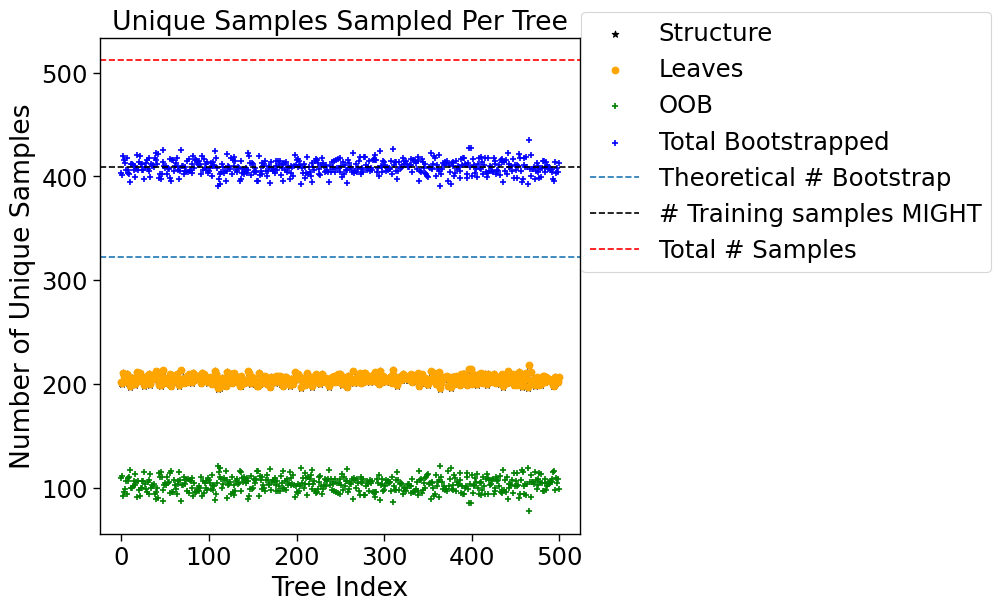

In [166]:
# Create a stacked area plot
fig, ax = plt.subplots(figsize=(10, 6), layout="constrained")

ax.scatter(
    np.arange(n_estimators),
    structure_cumulative,
    color="black",
    marker="*",
    label="Structure",
)
ax.scatter(
    np.arange(n_estimators),
    honest_cumulative,
    color="orange",
    marker="o",
    label="Leaves",
)
ax.scatter(
    np.arange(n_estimators), oob_cumulative, color="green", marker="+", label="OOB"
)

ax.scatter(
    np.arange(n_estimators),
    structure_cumulative + honest_cumulative,
    color="blue",
    marker="+",
    label="Total Bootstrapped",
)
ax.axhline([int(n_samples * 0.63)], ls="--", label="Theoretical # Bootstrap")
ax.axhline(
    [int(n_samples * 0.8)], color="black", ls="--", label="# Training samples MIGHT"
)
ax.axhline([n_samples], color="red", ls="--", label="Total # Samples")
ax.set(
    xlabel="Tree Index",
    ylabel="Number of Unique Samples",
    title="Unique Samples Sampled Per Tree",
)

fig.legend(loc="outside right upper")

plt.show()

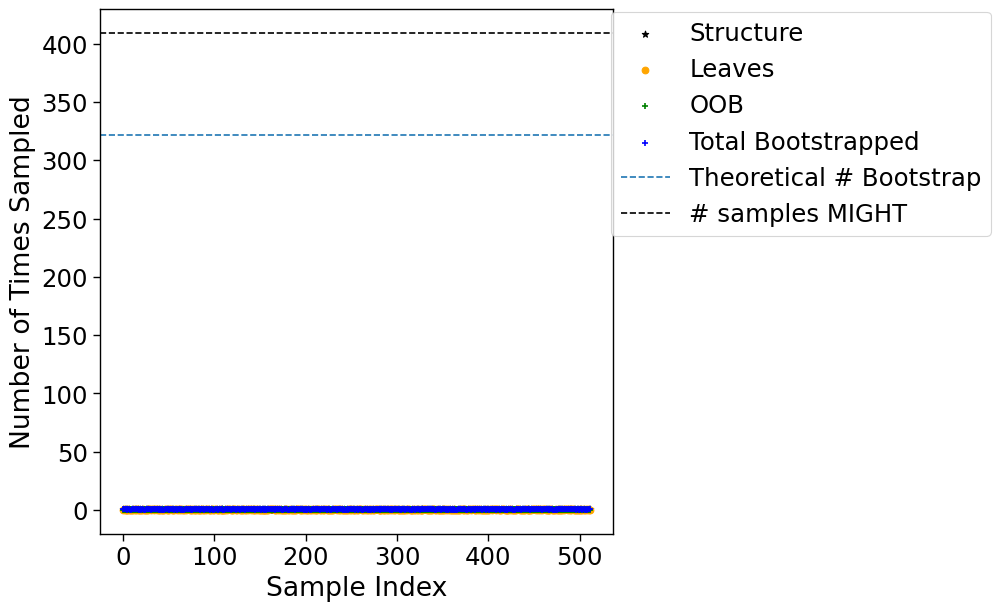

In [160]:
# Create a stacked area plot
fig, ax = plt.subplots(figsize=(10, 6), layout="constrained")

ax.scatter(
    np.arange(n_samples), structure_arr, color="black", marker="*", label="Structure"
)
ax.scatter(np.arange(n_samples), honest_arr, color="orange", marker="o", label="Leaves")
ax.scatter(np.arange(n_samples), oob_arr, color="green", marker="+", label="OOB")

ax.scatter(
    np.arange(n_samples),
    structure_arr + honest_arr,
    color="blue",
    marker="+",
    label="Total Bootstrapped",
)
ax.axhline([int(n_samples * 0.63)], ls="--", label="Theoretical # Bootstrap")
ax.axhline([int(n_samples * 0.8)], color="black", ls="--", label="# samples MIGHT")
ax.set(xlabel="Sample Index", ylabel="Number of Times Sampled")
fig.legend(loc="outside right upper")

# ax.axhline([n_estimators], ls="--", label="Number of Trees")

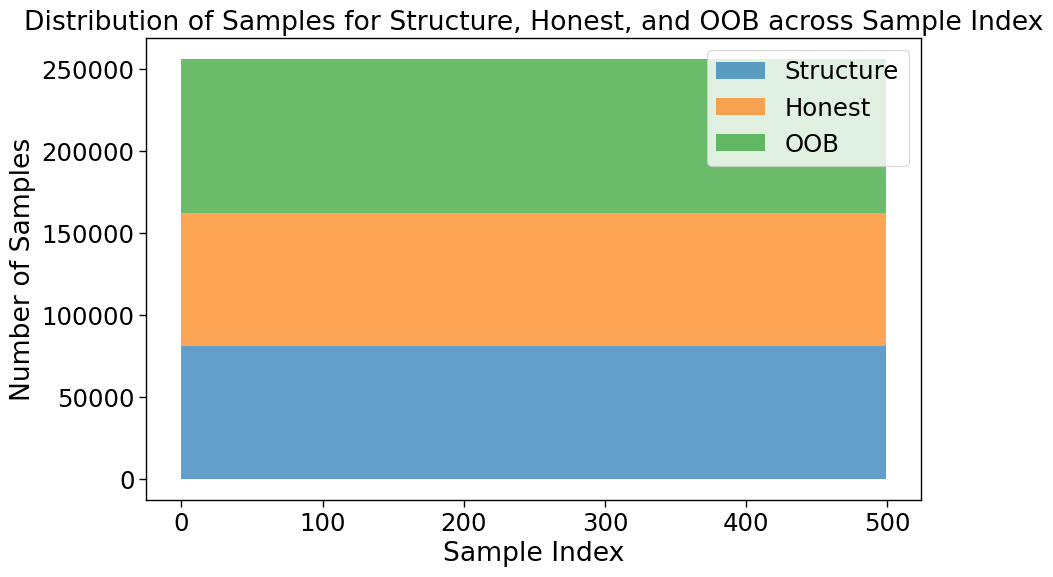

In [75]:
# Sum along the trees to get the cumulative counts for each category
# structure_cumulative = np.cumsum(structure_samples, axis=0)
# honest_cumulative = np.cumsum(honest_samples, axis=0)
# oob_cumulative = np.cumsum(oob_samples, axis=0)

# Create a stacked area plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the stacked areas
ax.fill_between(
    range(structure_samples.shape[0]),
    0,
    structure_cumulative[:, -1],
    label="Structure",
    alpha=0.7,
)
ax.fill_between(
    range(honest_samples.shape[0]),
    structure_cumulative[:, -1],
    structure_cumulative[:, -1] + honest_cumulative[:, -1],
    label="Honest",
    alpha=0.7,
)
ax.fill_between(
    range(oob_samples.shape[0]),
    structure_cumulative[:, -1] + honest_cumulative[:, -1],
    structure_cumulative[:, -1] + honest_cumulative[:, -1] + oob_cumulative[:, -1],
    label="OOB",
    alpha=0.7,
)

ax.set_xlabel("Sample Index")
ax.set_ylabel("Number of Samples")
ax.set_title(
    "Distribution of Samples for Structure, Honest, and OOB across Sample Index"
)
ax.legend()

plt.show()